In [212]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

## Utility Functions
Utility functions to assist to debugging and visualize results

In [315]:
def to_rgb(img):
    if img.ndim == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        return to_color(img)
    
                                      
def to_bgr(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
def plot_images(images, figsize=(12,6), titles=None):
    fig, ax = plt.subplots(1, len(images), figsize=figsize)
    for i in range(len(images)):
        image = images[i]
        if image.ndim == 3:
            ax[i].imshow(image)
        else:
            ax[i].imshow(image, cmap='gray')
        if titles != None and len(titles) > i:
            ax[i].set_title(titles[i])

        
def draw_line(img, pt1, pt2, color=[255, 0, 0], thickness=2):
    ''' draw a line on an image given two endpoints of the line '''
    cv2.line(img, (pt1[0], pt1[1]), (pt2[0], pt2[1]), color, thickness)

def draw_trapezoid(img, points):
    ''' draw a trapezoid given the four points in a list '''
    draw_line(img, points[0], points[1], thickness=3)
    draw_line(img, points[1], points[2], thickness=3)
    draw_line(img, points[2], points[3], thickness=3)
    draw_line(img, points[3], points[0], thickness=3)
                                      
def to_color(img):
    ''' convert 1 channel (grayscale) image to 3 channels '''
    if img.ndim == 2:
        normalized = np.uint8((img / np.max(img)) * 255)
        return np.dstack((normalized, normalized, normalized))
    else:
        return img

def combine_images(image1, image2, image3, image4):
    ''' combine 4 same resolution images into 1 by shrinking each image by half on x and y direction '''
    #shrink each image by a half on x and y direction
    r1 = cv2.resize(to_color(image1), None, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    r2 = cv2.resize(to_color(image2), None, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    r3 = cv2.resize(to_color(image3), None, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    r4 = cv2.resize(to_color(image4), None, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    
    #combine images 1,2 and 3,4 horizontally
    hcombined1 = np.concatenate((r1, r2), axis=1)
    hcombined2 = np.concatenate((r3, r4), axis=1)   
    
    #combine the result vertically
    vcombined = np.concatenate((hcombined1, hcombined2), axis=0)
    
    return vcombined

## Calibrate Camera

mtx [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] dist [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


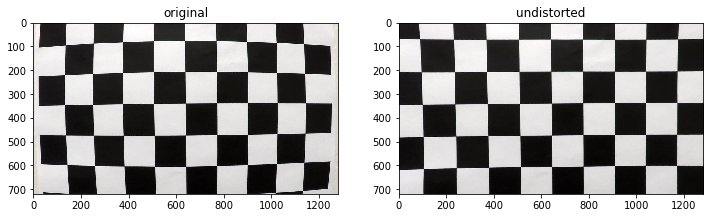

In [293]:
class Camera:
    ''' Calibrate camera and undistort pictures taken by the camera'''
    def __init__(self):
        self.mtx = []
        self.dist = []
        
    def calibrate(self):
        ''' calibrate the camera '''
        nx = 9 # number of inside corners in x
        ny = 6 # number of inside cornders in y
        
        # determine the object points and image points with chessboard images
        objpoints = []
        imgpoints = []
        
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)    

        fnames = glob.glob('./camera_cal/calibration*.jpg')
        for fname in fnames:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
             # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        
        image = cv2.imread('camera_cal/calibration1.jpg')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx) 
    
    def example(self):
        img = cv2.imread('camera_cal/calibration1.jpg')
        img_undist = self.undistort(img)
        print("mtx", self.mtx, "dist", self.dist)
        plot_images([to_rgb(img), to_rgb(img_undist)], titles=['original','undistorted'])


camera = Camera()
camera.calibrate()
camera.example()


In [308]:
# save an example of undistort
img = cv2.imread('test_images/test1.jpg')
img_undist = camera.undistort(img)
plt.imsave('output_images/undist.jpg', to_rgb(img_undist))

## Threshold Transform
Apply different threshold to transform an image

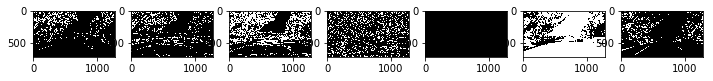

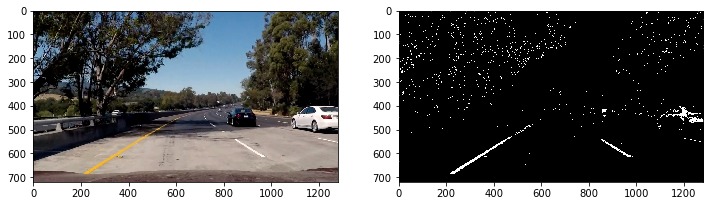

In [215]:
class ThresholdTransformer:
    
    def __init__(self, img):
        self.img = img
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.sobelx_output = np.zeros_like(self.gray)
        self.sobely_output = np.zeros_like(self.gray)
        self.magnitude_output = np.zeros_like(self.gray)
        self.direction_output = np.zeros_like(self.gray)
        self.hls_h_output = np.zeros_like(self.gray)
        self.hls_l_output = np.zeros_like(self.gray)
        self.hls_s_output = np.zeros_like(self.gray)
        self.combined_output = np.zeros_like(self.gray)

    def sobelx(self, min=0, max=255):
        # Apply x gradient with the OpenCV Sobel() function and take the absolute value
        abs_sobel = np.absolute(cv2.Sobel(self.gray, cv2.CV_64F, 1, 0))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        self.sobelx_output = np.zeros_like(scaled_sobel)
        self.sobelx_output[(scaled_sobel >= min) & (scaled_sobel <= max)] = 1
        #return result
        return self.sobelx_output
    
    def sobely(self, min=0, max=255):
        # Apply y gradient with the OpenCV Sobel() function and take the absolute value
        abs_sobel = np.absolute(cv2.Sobel(self.gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))        
        # Create a copy and apply the threshold
        self.sobely_output = np.zeros_like(scaled_sobel)
        self.sobely_output[(scaled_sobel >= min) & (scaled_sobel <= max)] = 1
        # return result
        return self.sobely_output
    
    def magnitude(self, kernel=3, min=0, max=255):
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=kernel)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        self.magnitude_output = np.zeros_like(gradmag)
        self.magnitude_output[(gradmag >= min) & (gradmag <= max)] = 1
        # return result
        return self.magnitude_output
    
    def direction(self, kernel=3, min=0, max=np.pi/2):
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=kernel)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        self.direction_output =  np.zeros_like(absgraddir)
        self.direction_output[(absgraddir >= min) & (absgraddir <= max)] = 1
        #return result
        return self.direction_output
    
    def hls_h(self, min=0, max=255):
        # Convert to HLS color space
        hls = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)
        H = hls[:,:,0]
        # Threshold color channel
        self.hls_h_output = np.zeros_like(H)
        # Apply Threshold
        self.hls_h_output[(H >= min) & (H <= max)] = 1
        #return result
        return self.hls_h_output
    
    def hls_l(self, min=0, max=255):
        # Convert to HLS color space
        hls = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)
        L = hls[:,:,1]
        # Threshold color channel
        self.hls_l_output = np.zeros_like(L)
        # Apply Threshold
        self.hls_l_output[(L >= min) & (L <= max)] = 1
        #return result
        return self.hls_l_output       
    
    def hls_s(self, min=0, max=255):
        # Convert to HLS color space
        hls = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)
        S = hls[:,:,2]
        # Threshold color channel
        self.hls_s_output = np.zeros_like(S)
        # Apply Threshold
        self.hls_s_output[(S >= min) & (S <= max)] = 1
        #return result
        return self.hls_s_output
    
    def render(self):
        self.combined_output = np.zeros_like(self.gray)
        '''
        self.combined_output[(self.hls_h_output==1) | \
                 (self.hls_l_output==1) | \
                 (self.hls_s_output==1) | \
                 ((self.sobelx_output==1) & \
                  (self.sobely_output==1) & \
                  (self.magnitude_output==1) & \
                  (self.direction_output==1))] = 1
        '''
        self.combined_output[((self.hls_h_output==1) & \
                 (self.hls_l_output==1) & \
                 (self.hls_s_output==1)) | \
                 ((self.sobelx_output==1) & \
                  (self.sobely_output==1) & \
                  (self.magnitude_output==1) & \
                  (self.direction_output==1))] = 1        
        return self.combined_output

    def render_preconfigured(self):
        self.sobelx(20,100)
        self.sobely(20,100)
        self.magnitude(21,20,100)
        self.direction(21,0.7,1.1)
        self.hls_h(0, 255)
        self.hls_l(30, 255)
        self.hls_s(150,255)
        return self.render()
    
    def test(self):
        self.render_preconfigured()
        plot_images([self.sobelx_output, 
                     self.sobely_output, 
                     self.magnitude_output, 
                     self.direction_output,
                     self.hls_h_output,
                     self.hls_l_output,
                     self.hls_s_output])
        plot_images([to_rgb(self.img), self.combined_output])
        
    def plot_steps(self):
        self.render()
        plot_images([self.sobelx_output, 
                     self.sobely_output, 
                     self.magnitude_output, 
                     self.direction_output,
                     self.hls_h_output,
                     self.hls_l_output,
                     self.hls_s_output])
        plot_images([to_rgb(self.img), self.combined_output])

# test it on an image
ThresholdTransformer(cv2.imread('./test_images/test5.jpg')).test()

In [311]:
t_transformer = ThresholdTransformer(cv2.imread('./test_images/test1.jpg'))
t_transformer.render_preconfigured()
plt.imsave('output_images/threshold.jpg', t_transformer.combined_output, cmap='gray')

## Perspective Transform

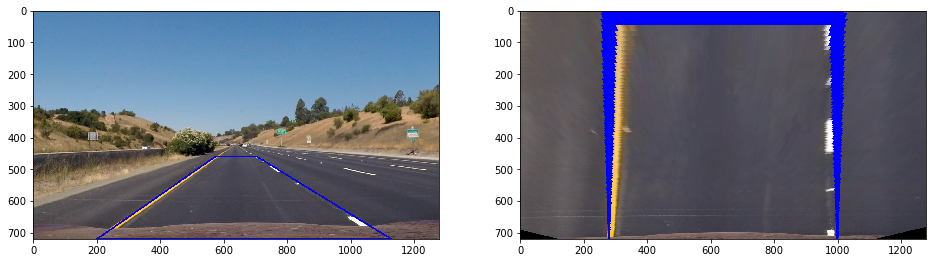

In [319]:
class PerspectiveTransformer:
    SRC = np.float32([(575,460), (705,460), (1130, 720), (200, 720)])
    DST = np.float32([(280, 0),  (1000, 0), (1000, 720), (280, 720)])
    
    def __init__(self):
        # Compute the perspective transform
        self.M = cv2.getPerspectiveTransform(self.SRC, self.DST) 
        #Compute the inverse perspective transform:
        self.Minv = cv2.getPerspectiveTransform(self.DST, self.SRC)
    
    def warp(self, img):
        ''' apply perspective transform '''
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self.M, img_size, flags=cv2.INTER_NEAREST)
    
    def unwarp(self, img):
        ''' apply inverse perspective transform '''
        img_size = (img.shape[1], img.shape[0])    
        return cv2.warpPerspective(img, self.Minv, img_size, flags=cv2.INTER_NEAREST)
    
    def birds_eye_view(self, img):
        return self.warp(img)
    
    def test(self, img, camera):
        img_undistort = camera.undistort(img)
        draw_trapezoid(img, self.SRC)
        draw_trapezoid(img_undistort, self.SRC)
        img_bev = self.birds_eye_view(img_undistort)
        plot_images([to_rgb(img), to_rgb(img_bev)], figsize=(16,16))
        
PerspectiveTransformer().test(cv2.imread('./test_images/straight_lines1.jpg'), camera)


## Threshold Transform Parameter Tuning
Use ipython widget to interatively find optimal parameters for threshold transform.

<function __main__.explore>

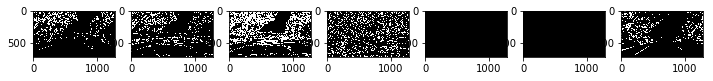

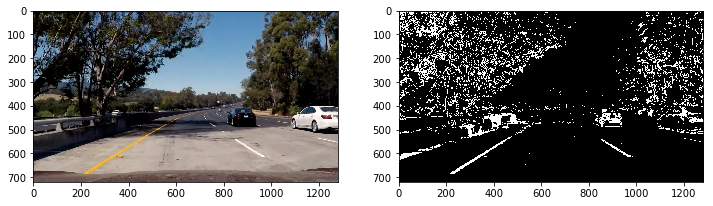

In [217]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

img_test = cv2.imread('./test_images/test5.jpg')

def explore(ksize=21, 
            sobelx_min=20, 
            sobelx_max=100, 
            sobely_min=20, 
            sobely_max=100, 
            magnitude_min=20, 
            magnitude_max=100, 
            direction_min=0.7, 
            direction_max=1.1, 
            hls_h_min=0, 
            hls_h_max=255,
            hls_l_min=0,
            hls_l_max=255,
            hls_s_min=150,
            hls_s_max=255):
    transformer = ThresholdTransformer(img_test)
    transformer.sobelx(sobelx_min, sobelx_max)
    transformer.sobely(sobely_min, sobelx_max)
    transformer.magnitude(ksize, magnitude_min, magnitude_max)
    transformer.direction(ksize, direction_min, direction_max)
    transformer.hls_h(hls_h_min, hls_h_max)
    transformer.hls_l(hls_l_min, hls_l_max)
    transformer.hls_s(hls_s_min, hls_s_max)
    transformer.render()
    transformer.plot_steps()
    #plot_images([to_rgb(img_test), transformer.combined_output])
    
interact(explore,
         ksize=(1,31,2),
         sobelx_min=(0,255),
         sobelx_max=(0,255), 
         sobely_min=(0,255), 
         sobely_max=(0,255), 
         magnitude_min=(0,255), 
         magnitude_max=(0,255), 
         direction_min=(0, np.pi/2), 
         direction_max=(0, np.pi/2), 
         hls_h_min=(0,255), 
         hls_h_max=(0,255),
         hls_l_min=(0,255), 
         hls_l_max=(0,255),         
         hls_s_min=(0,255),
         hls_s_max=(0,255))


## Run the pipeline on all test images

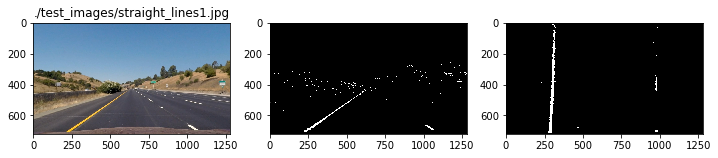

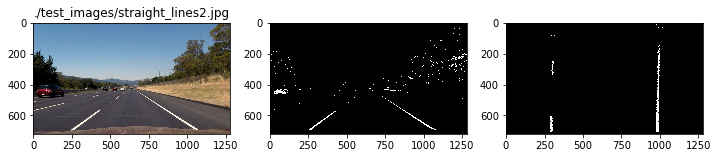

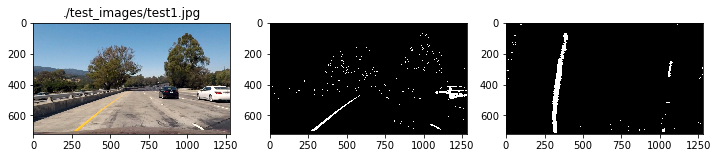

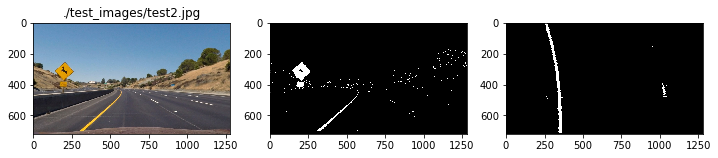

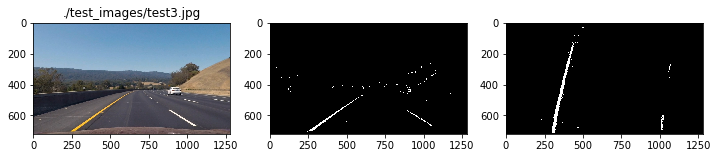

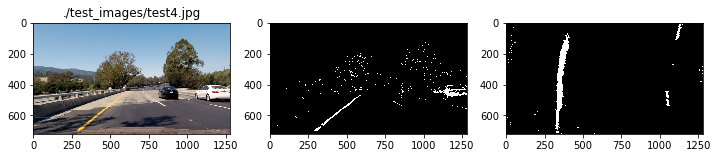

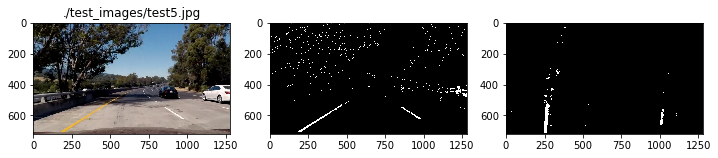

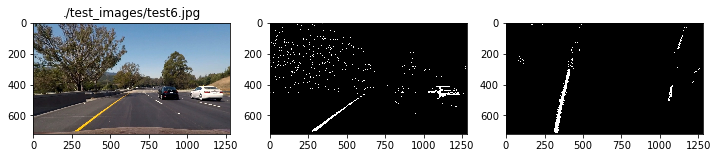

In [180]:
###### test pipeline

fnames = glob.glob('./test_images/*.jpg')

for fname in fnames:
    img = cv2.imread(fname)
    img_undistort = camera.undistort(img)
    img_pre_bev = ThresholdTransformer(img_undistort).render_preconfigured()
    img_bev = PerspectiveTransformer().birds_eye_view(img_undistort)
    img_final = ThresholdTransformer(img_bev).render_preconfigured()
    plot_images([to_rgb(img_undistort), img_pre_bev, img_final], titles=[fname])
    

## Locate Lane Lines

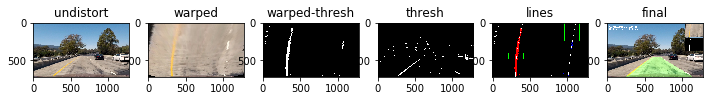

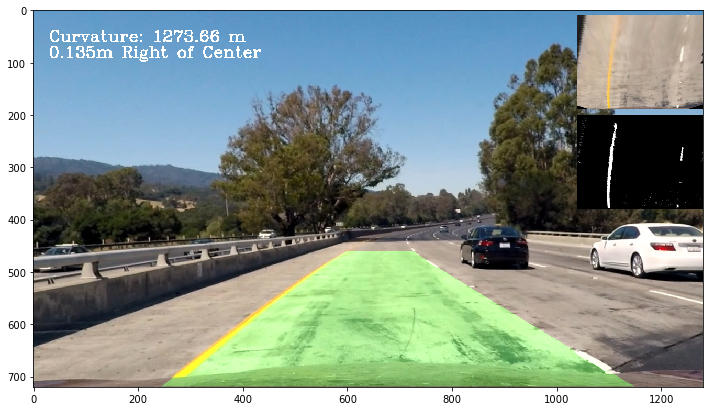

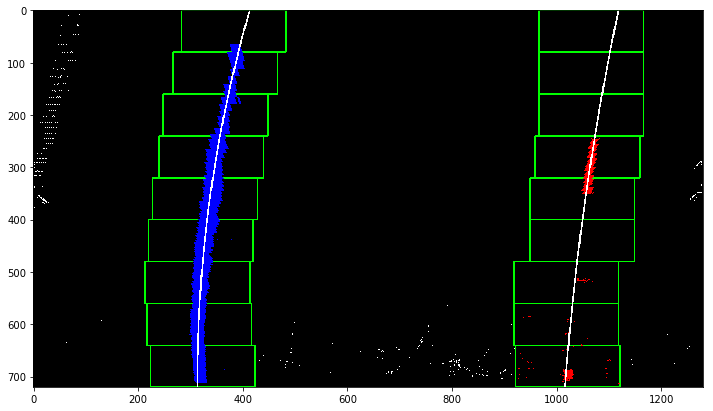

In [327]:
class LaneFinder:
    
    def __init__(self, camera, debug=False):
        self.camera = camera
        self.img = None
        self.img_undist = None
        self.img_warped = None
        self.img_warped_thresh = None
        self.img_thresh = None
        self.img_lines = None
        self.img_final = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset = None
        self.ploty = None
    
    def mark_lane_lines(self, img):
        self.img = img
        # undistort
        self.img_undist = self.camera.undistort(img)
        # warp / create birds eye view
        self.img_warped = PerspectiveTransformer().warp(self.img_undist)
        # apply threshold
        self.img_warped_thresh = ThresholdTransformer(self.img_warped).render_preconfigured()
        # for debug - apply threshold before warp
        self.img_thresh = ThresholdTransformer(self.img_undist).render_preconfigured()
        
        # find lane lines
        self.find_lines()

        # project found lane lines on the road
        self.project_lines()
        
        # calculate curvature and center offset
        self.calc_road_info()
        
        # draw curvature and center offset info on image
        self.draw_road_info()
        
        self.draw_diag_images()
        
    def plot_images(self):   
        plot_images([to_rgb(self.img_undist), 
                     to_rgb(self.img_warped), 
                     self.img_warped_thresh,
                     self.img_thresh,
                     self.img_lines,
                     to_rgb(self.img_final)], 
                    titles=['undistort','warped','warped-thresh','thresh','lines','final'])        
        plt.figure(figsize=(12,8))
        plt.imshow(to_rgb(self.img_final))
    
    def find_lines(self):
        binary_warped = self.img_warped_thresh
        
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
        # Create an output image to draw on and  visualize the result for debugging
        self.img_lines = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
    
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minpix = 50
    
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(self.img_lines,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(self.img_lines,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        self.img_lines[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        self.img_lines[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        cv2.polylines(self.img_lines, [np.int32(tuple(zip(left_fitx,ploty)))], False, color=(255,255,255), thickness=2)
        cv2.polylines(self.img_lines, [np.int32(tuple(zip(right_fitx,ploty)))], False, color=(255,255,255), thickness=2)
    
        self.ploty = ploty
        self.left_fit = left_fit
        self.right_fit = right_fit
        
    def find_lines_using_previous_fit(self, previous_left_fit, previous_right_fit):
        binary_warped = self.img_warped_thresh
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (p_left_fit[0]*(nonzeroy**2) + p_left_fit[1]*nonzeroy + p_left_fit[2] - margin)) & (nonzerox < (p_left_fit[0]*(nonzeroy**2) + p_left_fit[1]*nonzeroy + p_left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (p_right_fit[0]*(nonzeroy**2) + p_right_fit[1]*nonzeroy + p_right_fit[2] - margin)) & (nonzerox < (p_right_fit[0]*(nonzeroy**2) + p_right_fit[1]*nonzeroy + p_right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
    
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [128, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 128]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,100, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,100, 0))
        self.img_lines = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)
    
        self.left_fit = left_fit
        self.right_fit = right_fit

    
    def calc_road_info(self):
        left_fit = self.left_fit
        right_fit = self.right_fit
        ploty = self.ploty
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]        
        y_eval = np.max(ploty)
        #left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        #right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        self.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 
        self.center_offset = ((((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) + 
                         (right_fit[0]*720**2+right_fit[1]*720+right_fit[2])) / 2) - 640) * xm_per_pix
        
    def project_lines(self):
        left_fit = self.left_fit
        right_fit = self.right_fit
        ploty = self.ploty
        warped = self.img_warped_thresh
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Generate x and y values for plotting
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        
        # Combine the result with the original image
        self.img_final = cv2.addWeighted(self.img_undist, 1, newwarp, 0.3, 0)      
    
    def draw_road_info(self):
        curverad = (self.left_curverad + self.right_curverad) / 2
        cv2.putText(self.img_final, 'Curvature: {:.2f} m'.format(curverad), (30, 60), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 2)
        if self.center_offset < 0:
            offset_text = '{:.3f}m Left of Center'.format(self.center_offset*-1)
        else:
            offset_text = '{:.3f}m Right of Center'.format(self.center_offset)    
        cv2.putText(self.img_final, offset_text, (30, 90), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 2)
        
    def draw_diag_images(self):
        self.img_final[10:190,1040:1280] = cv2.resize(self.img_warped, (240,180), interpolation=cv2.INTER_AREA) 
        self.img_final[200:380,1040:1280] = cv2.resize(to_rgb(self.img_warped_thresh), (240,180), interpolation=cv2.INTER_AREA) 

    def is_good_detection(self):
        ''' return whether good lane lines were detected '''
        if self.left_curverad < 200:
            return False
        if self.right_curverad < 200:
            return False
        return True
        
'''
fnames = glob.glob('./test_images/*.jpg')
for fname in fnames:
    img = cv2.imread(fname)
    finder = LaneFinder(camera)
    finder.mark_lane_lines(img)
'''    
img = cv2.imread('./test_images/test1.jpg')
finder = LaneFinder(camera)
finder.mark_lane_lines(img)
finder.plot_images()

plt.figure(figsize=(12,8))
plt.imshow(to_rgb(finder.img_lines))
plt.imsave('output_images/project-lines.jpg', to_rgb(finder.img_final))

#print(finder.is_good_detection(), finder.right_curverad, finder.left_curverad)


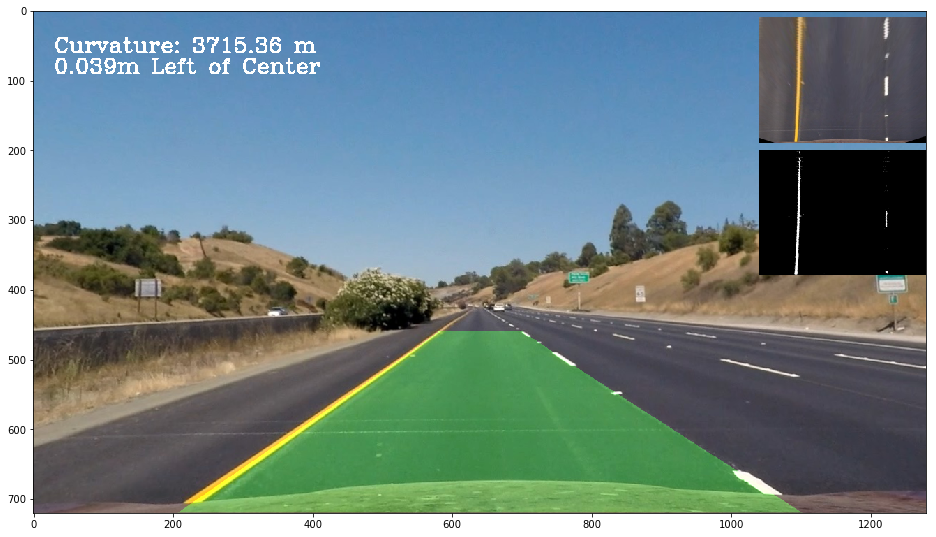

In [289]:
last_good_frame = None
def process_video_image(img):
    global last_good_frame
    finder = LaneFinder(camera)
    
    # video image are in rgb, convert to bgr first
    finder.mark_lane_lines(to_bgr(img))        
    
    if finder.is_good_detection() or last_good_frame == None:
        # convert result image back to rgb
        # save the current frame as last good frame
        last_good_frame = to_rgb(finder.img_final)
    else:
        #debug
        print("Bad Detection! left:{:.2f} right:{:.2f}".format(finder.left_curverad, finder.right_curverad))

    return last_good_frame


img = cv2.imread('./test_images/straight_lines1.jpg')
img_result = process_video_image(to_rgb(img))
plt.figure(figsize=(16,16))
plt.imshow(img_result)



In [290]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = process_video_image(image)
    
    return result

In [291]:
video_output_file = 'project_video_out.mp4'
input_video = VideoFileClip("project_video.mp4")
output_video = input_video.fl_image(process_image) #NOTE: this function expects color images!!
%time output_video.write_videofile(video_output_file, audio=False)




[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<09:48,  2.14it/s]


  0%|          | 2/1261 [00:00<09:42,  2.16it/s]


  0%|          | 3/1261 [00:01<09:41,  2.16it/s]


  0%|          | 4/1261 [00:01<09:53,  2.12it/s]


  0%|          | 5/1261 [00:02<10:02,  2.09it/s]


  0%|          | 6/1261 [00:02<10:12,  2.05it/s]


  1%|          | 7/1261 [00:03<10:14,  2.04it/s]


  1%|          | 8/1261 [00:03<10:17,  2.03it/s]


  1%|          | 9/1261 [00:04<10:19,  2.02it/s]


  1%|          | 10/1261 [00:04<10:14,  2.04it/s]


  1%|          | 11/1261 [00:05<11:04,  1.88it/s]


  1%|          | 12/1261 [00:05<10:44,  1.94it/s]


  1%|          | 13/1261 [00:06<10:21,  2.01it/s]


  1%|          | 14/1261 [00:06<10:09,  2.04it/s]


  1%|          | 15/1261 [00:07<09:54,  2.10it/s]


  1%|▏         | 16/1261 [00:07<09:45,  2.13it/s]


  1%|▏         | 17/1261 [00:08<09:38,  2.15it/s]


  1%|▏         | 18/1261 [00:08<09:35,  2.16it/s]


  2%|▏         | 19/1261 [0

Bad Detection! left:3862.96 right:263.53





 47%|████▋     | 590/1261 [04:33<04:59,  2.24it/s]

Bad Detection! left:1301.49 right:274.47





 47%|████▋     | 591/1261 [04:34<04:59,  2.24it/s]

Bad Detection! left:2842.25 right:352.61





 47%|████▋     | 592/1261 [04:34<05:00,  2.23it/s]


 47%|████▋     | 593/1261 [04:35<04:59,  2.23it/s]

Bad Detection! left:1154.65 right:387.49





 47%|████▋     | 594/1261 [04:35<04:58,  2.23it/s]


 47%|████▋     | 595/1261 [04:35<04:58,  2.23it/s]


 47%|████▋     | 596/1261 [04:36<04:58,  2.23it/s]


 47%|████▋     | 597/1261 [04:36<04:59,  2.22it/s]


 47%|████▋     | 598/1261 [04:37<04:59,  2.21it/s]


 48%|████▊     | 599/1261 [04:37<05:00,  2.20it/s]


 48%|████▊     | 600/1261 [04:38<05:00,  2.20it/s]


 48%|████▊     | 601/1261 [04:38<04:59,  2.20it/s]


 48%|████▊     | 602/1261 [04:39<04:58,  2.20it/s]


 48%|████▊     | 603/1261 [04:39<04:57,  2.21it/s]


 48%|████▊     | 604/1261 [04:40<04:56,  2.21it/s]


 48%|████▊     | 605/1261 [04:40<04:55,  2.22it/s]


 48%|████▊     | 606/1261 [04:40<04:56,  2.21it/s]


 48%|████▊     | 607/1261 [04:41<04:54,  2.22it/s]


 48%|████▊     | 608/1261 [04:41<04:53,  2.23it/s]


 48%|████▊     | 609/1261 [04:42<04:51,  2.24it/s]


 48%|████▊     | 610/1261 [04:42<04:50,  2.24it/s]


 48%|████▊     | 611/1261 [04:43<04:49,  2.25it/s]


 49%|████▊     | 612/1261 [04:43<04:48,  2.

Bad Detection! left:614.37 right:5.80





 49%|████▉     | 616/1261 [04:45<04:46,  2.25it/s]

Bad Detection! left:561.09 right:373.73





 49%|████▉     | 617/1261 [04:45<04:46,  2.25it/s]

Bad Detection! left:524.27 right:12.20





 49%|████▉     | 618/1261 [04:46<04:45,  2.25it/s]

Bad Detection! left:477.58 right:3.19





 49%|████▉     | 619/1261 [04:46<04:44,  2.25it/s]


 49%|████▉     | 620/1261 [04:47<04:44,  2.25it/s]


 49%|████▉     | 621/1261 [04:47<04:45,  2.25it/s]


 49%|████▉     | 622/1261 [04:48<04:44,  2.25it/s]


 49%|████▉     | 623/1261 [04:48<04:43,  2.25it/s]


 49%|████▉     | 624/1261 [04:48<04:42,  2.25it/s]


 50%|████▉     | 625/1261 [04:49<04:42,  2.25it/s]


 50%|████▉     | 626/1261 [04:49<04:41,  2.25it/s]


 50%|████▉     | 627/1261 [04:50<04:42,  2.24it/s]

Bad Detection! left:409.85 right:0.64





 50%|████▉     | 628/1261 [04:50<04:42,  2.24it/s]


 50%|████▉     | 629/1261 [04:51<04:41,  2.24it/s]


 50%|████▉     | 630/1261 [04:51<04:41,  2.24it/s]

Bad Detection! left:635.03 right:397.15





 50%|█████     | 631/1261 [04:52<04:42,  2.23it/s]

Bad Detection! left:852.16 right:339.31





 50%|█████     | 632/1261 [04:52<04:42,  2.23it/s]

Bad Detection! left:1123.15 right:381.99





 50%|█████     | 633/1261 [04:52<04:42,  2.23it/s]


 50%|█████     | 634/1261 [04:53<04:42,  2.22it/s]


 50%|█████     | 635/1261 [04:53<04:41,  2.22it/s]


 50%|█████     | 636/1261 [04:54<04:41,  2.22it/s]


 51%|█████     | 637/1261 [04:54<04:41,  2.22it/s]


 51%|█████     | 638/1261 [04:55<04:41,  2.22it/s]


 51%|█████     | 639/1261 [04:55<04:40,  2.22it/s]


 51%|█████     | 640/1261 [04:56<04:39,  2.22it/s]


 51%|█████     | 641/1261 [04:56<04:39,  2.22it/s]


 51%|█████     | 642/1261 [04:57<04:38,  2.22it/s]


 51%|█████     | 643/1261 [04:57<04:41,  2.20it/s]


 51%|█████     | 644/1261 [04:57<04:44,  2.17it/s]


 51%|█████     | 645/1261 [04:58<04:42,  2.18it/s]


 51%|█████     | 646/1261 [04:58<04:42,  2.18it/s]


 51%|█████▏    | 647/1261 [04:59<04:41,  2.18it/s]


 51%|█████▏    | 648/1261 [04:59<04:40,  2.18it/s]


 51%|█████▏    | 649/1261 [05:00<04:39,  2.19it/s]


 52%|█████▏    | 650/1261 [05:00<04:38,  2.19it/s]


 52%|█████▏    | 651/1261 [05:01<04:37,  2.

Bad Detection! left:1206.89 right:325.54





 52%|█████▏    | 656/1261 [05:03<04:34,  2.21it/s]


 52%|█████▏    | 657/1261 [05:03<04:33,  2.21it/s]


 52%|█████▏    | 658/1261 [05:04<04:33,  2.21it/s]


 52%|█████▏    | 659/1261 [05:04<04:32,  2.21it/s]


 52%|█████▏    | 660/1261 [05:05<04:32,  2.21it/s]


 52%|█████▏    | 661/1261 [05:05<04:31,  2.21it/s]


 52%|█████▏    | 662/1261 [05:06<04:31,  2.21it/s]


 53%|█████▎    | 663/1261 [05:06<04:30,  2.21it/s]


 53%|█████▎    | 664/1261 [05:07<04:30,  2.21it/s]


 53%|█████▎    | 665/1261 [05:07<04:29,  2.21it/s]


 53%|█████▎    | 666/1261 [05:07<04:30,  2.20it/s]


 53%|█████▎    | 667/1261 [05:08<04:32,  2.18it/s]

Bad Detection! left:773.03 right:347.51





 53%|█████▎    | 668/1261 [05:08<04:31,  2.19it/s]


 53%|█████▎    | 669/1261 [05:09<04:29,  2.19it/s]


 53%|█████▎    | 670/1261 [05:09<04:28,  2.20it/s]


 53%|█████▎    | 671/1261 [05:10<04:28,  2.19it/s]


 53%|█████▎    | 672/1261 [05:10<04:28,  2.19it/s]


 53%|█████▎    | 673/1261 [05:11<04:27,  2.20it/s]


 53%|█████▎    | 674/1261 [05:11<04:27,  2.20it/s]


 54%|█████▎    | 675/1261 [05:12<04:25,  2.20it/s]


 54%|█████▎    | 676/1261 [05:12<04:25,  2.21it/s]


 54%|█████▎    | 677/1261 [05:12<04:24,  2.21it/s]


 54%|█████▍    | 678/1261 [05:13<04:23,  2.21it/s]


 54%|█████▍    | 679/1261 [05:13<04:22,  2.21it/s]


 54%|█████▍    | 680/1261 [05:14<04:22,  2.22it/s]

Bad Detection! left:1363.02 right:373.70





 54%|█████▍    | 681/1261 [05:14<04:21,  2.21it/s]


 54%|█████▍    | 682/1261 [05:15<04:21,  2.21it/s]


 54%|█████▍    | 683/1261 [05:15<04:20,  2.22it/s]


 54%|█████▍    | 684/1261 [05:16<04:20,  2.22it/s]


 54%|█████▍    | 685/1261 [05:16<04:19,  2.22it/s]


 54%|█████▍    | 686/1261 [05:16<04:19,  2.21it/s]


 54%|█████▍    | 687/1261 [05:17<04:18,  2.22it/s]


 55%|█████▍    | 688/1261 [05:17<04:18,  2.22it/s]


 55%|█████▍    | 689/1261 [05:18<04:17,  2.22it/s]


 55%|█████▍    | 690/1261 [05:18<04:16,  2.22it/s]


 55%|█████▍    | 691/1261 [05:19<04:16,  2.22it/s]


 55%|█████▍    | 692/1261 [05:19<04:16,  2.22it/s]


 55%|█████▍    | 693/1261 [05:20<04:15,  2.22it/s]


 55%|█████▌    | 694/1261 [05:20<04:14,  2.23it/s]


 55%|█████▌    | 695/1261 [05:21<04:14,  2.23it/s]


 55%|█████▌    | 696/1261 [05:21<04:13,  2.23it/s]


 55%|█████▌    | 697/1261 [05:21<04:12,  2.23it/s]


 55%|█████▌    | 698/1261 [05:22<04:12,  2.23it/s]


 55%|█████▌    | 699/1261 [05:22<04:11,  2.

Bad Detection! left:733.88 right:382.26





 59%|█████▉    | 741/1261 [05:41<03:57,  2.19it/s]


 59%|█████▉    | 742/1261 [05:42<03:56,  2.19it/s]


 59%|█████▉    | 743/1261 [05:42<03:55,  2.20it/s]


 59%|█████▉    | 744/1261 [05:43<03:55,  2.20it/s]


 59%|█████▉    | 745/1261 [05:43<03:54,  2.20it/s]


 59%|█████▉    | 746/1261 [05:44<03:54,  2.20it/s]


 59%|█████▉    | 747/1261 [05:44<03:53,  2.20it/s]


 59%|█████▉    | 748/1261 [05:44<03:53,  2.20it/s]


 59%|█████▉    | 749/1261 [05:45<03:53,  2.20it/s]


 59%|█████▉    | 750/1261 [05:45<03:53,  2.19it/s]


 60%|█████▉    | 751/1261 [05:46<03:51,  2.20it/s]


 60%|█████▉    | 752/1261 [05:46<03:50,  2.20it/s]


 60%|█████▉    | 753/1261 [05:47<03:49,  2.21it/s]


 60%|█████▉    | 754/1261 [05:47<03:49,  2.21it/s]


 60%|█████▉    | 755/1261 [05:48<03:48,  2.22it/s]


 60%|█████▉    | 756/1261 [05:48<03:47,  2.22it/s]


 60%|██████    | 757/1261 [05:48<03:46,  2.22it/s]


 60%|██████    | 758/1261 [05:49<03:46,  2.22it/s]


 60%|██████    | 759/1261 [05:49<03:45,  2.

Bad Detection! left:3090.68 right:374.72





 79%|███████▊  | 991/1261 [07:36<02:00,  2.24it/s]


 79%|███████▊  | 992/1261 [07:36<02:00,  2.23it/s]


 79%|███████▊  | 993/1261 [07:37<01:59,  2.23it/s]


 79%|███████▉  | 994/1261 [07:37<01:59,  2.23it/s]


 79%|███████▉  | 995/1261 [07:38<01:59,  2.23it/s]


 79%|███████▉  | 996/1261 [07:38<01:58,  2.24it/s]


 79%|███████▉  | 997/1261 [07:39<01:58,  2.23it/s]


 79%|███████▉  | 998/1261 [07:39<01:57,  2.23it/s]


 79%|███████▉  | 999/1261 [07:40<01:57,  2.23it/s]


 79%|███████▉  | 1000/1261 [07:40<01:57,  2.22it/s]


 79%|███████▉  | 1001/1261 [07:40<01:56,  2.22it/s]


 79%|███████▉  | 1002/1261 [07:41<01:56,  2.22it/s]


 80%|███████▉  | 1003/1261 [07:41<01:56,  2.22it/s]


 80%|███████▉  | 1004/1261 [07:42<01:55,  2.22it/s]


 80%|███████▉  | 1005/1261 [07:42<01:55,  2.21it/s]


 80%|███████▉  | 1006/1261 [07:43<01:56,  2.20it/s]


 80%|███████▉  | 1007/1261 [07:43<02:12,  1.92it/s]

Bad Detection! left:2499.81 right:374.94





 80%|███████▉  | 1008/1261 [07:44<02:09,  1.95it/s]


 80%|████████  | 1009/1261 [07:44<02:05,  2.00it/s]


 80%|████████  | 1010/1261 [07:45<02:03,  2.03it/s]


 80%|████████  | 1011/1261 [07:45<02:01,  2.06it/s]


 80%|████████  | 1012/1261 [07:46<02:00,  2.07it/s]


 80%|████████  | 1013/1261 [07:46<01:58,  2.08it/s]


 80%|████████  | 1014/1261 [07:47<01:57,  2.10it/s]


 80%|████████  | 1015/1261 [07:47<01:57,  2.10it/s]


 81%|████████  | 1016/1261 [07:48<01:56,  2.10it/s]


 81%|████████  | 1017/1261 [07:48<01:59,  2.03it/s]


 81%|████████  | 1018/1261 [07:49<01:59,  2.03it/s]


 81%|████████  | 1019/1261 [07:49<01:58,  2.04it/s]


 81%|████████  | 1020/1261 [07:50<01:57,  2.04it/s]


 81%|████████  | 1021/1261 [07:50<01:56,  2.06it/s]


 81%|████████  | 1022/1261 [07:51<01:56,  2.05it/s]


 81%|████████  | 1023/1261 [07:51<01:55,  2.05it/s]


 81%|████████  | 1024/1261 [07:52<01:55,  2.05it/s]


 81%|████████▏ | 1025/1261 [07:52<01:53,  2.08it/s]


 81%|████████▏ | 1026/126

Bad Detection! left:1197.66 right:332.22





 82%|████████▏ | 1039/1261 [07:58<01:38,  2.25it/s]

Bad Detection! left:1585.82 right:220.17





 82%|████████▏ | 1040/1261 [07:59<01:38,  2.25it/s]

Bad Detection! left:1881.30 right:278.87





 83%|████████▎ | 1041/1261 [07:59<01:37,  2.25it/s]

Bad Detection! left:1837.57 right:307.50





 83%|████████▎ | 1042/1261 [08:00<01:38,  2.23it/s]


 83%|████████▎ | 1043/1261 [08:00<01:37,  2.24it/s]


 83%|████████▎ | 1044/1261 [08:01<01:36,  2.24it/s]

Bad Detection! left:900.40 right:371.38





 83%|████████▎ | 1045/1261 [08:01<01:35,  2.25it/s]


 83%|████████▎ | 1046/1261 [08:01<01:35,  2.26it/s]


 83%|████████▎ | 1047/1261 [08:02<01:34,  2.25it/s]

Bad Detection! left:683.11 right:298.26





 83%|████████▎ | 1048/1261 [08:02<01:35,  2.23it/s]


 83%|████████▎ | 1049/1261 [08:03<01:34,  2.23it/s]

Bad Detection! left:665.03 right:308.53





 83%|████████▎ | 1050/1261 [08:03<01:34,  2.24it/s]

Bad Detection! left:544.09 right:380.30





 83%|████████▎ | 1051/1261 [08:04<01:34,  2.22it/s]

Bad Detection! left:528.36 right:358.57





 83%|████████▎ | 1052/1261 [08:04<01:34,  2.20it/s]


 84%|████████▎ | 1053/1261 [08:05<01:35,  2.17it/s]


 84%|████████▎ | 1054/1261 [08:05<01:36,  2.14it/s]


 84%|████████▎ | 1055/1261 [08:06<01:36,  2.13it/s]


 84%|████████▎ | 1056/1261 [08:06<01:37,  2.11it/s]


 84%|████████▍ | 1057/1261 [08:07<01:36,  2.11it/s]


 84%|████████▍ | 1058/1261 [08:07<01:34,  2.14it/s]


 84%|████████▍ | 1059/1261 [08:07<01:33,  2.15it/s]


 84%|████████▍ | 1060/1261 [08:08<01:32,  2.18it/s]


 84%|████████▍ | 1061/1261 [08:08<01:31,  2.20it/s]


 84%|████████▍ | 1062/1261 [08:09<01:30,  2.21it/s]


 84%|████████▍ | 1063/1261 [08:09<01:29,  2.22it/s]


 84%|████████▍ | 1064/1261 [08:10<01:28,  2.22it/s]


 84%|████████▍ | 1065/1261 [08:10<01:27,  2.23it/s]


 85%|████████▍ | 1066/1261 [08:11<01:27,  2.23it/s]


 85%|████████▍ | 1067/1261 [08:11<01:26,  2.23it/s]


 85%|████████▍ | 1068/1261 [08:11<01:26,  2.23it/s]


 85%|████████▍ | 1069/1261 [08:12<01:26,  2.23it/s]


 85%|████████▍ | 1070/126

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 49s, sys: 1min 49s, total: 10min 38s
Wall time: 9min 41s


In [300]:
video_output_file = 'challenge_video_out.mp4'
input_video = VideoFileClip("challenge_video.mp4")
output_video = input_video.fl_image(process_image) #NOTE: this function expects color images!!
%time output_video.write_videofile(video_output_file, audio=False)

Bad Detection! left:186.71 right:492.69
[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<03:43,  2.16it/s]

Bad Detection! left:186.71 right:492.69




  0%|          | 2/485 [00:00<03:43,  2.16it/s]

Bad Detection! left:214.02 right:494.85




  1%|          | 3/485 [00:01<03:41,  2.18it/s]

Bad Detection! left:102.36 right:719.89




  1%|          | 4/485 [00:01<03:39,  2.19it/s]

Bad Detection! left:202.75 right:769.61




  1%|          | 5/485 [00:02<03:38,  2.20it/s]

Bad Detection! left:126.29 right:779.75




  1%|          | 6/485 [00:02<03:37,  2.20it/s]

Bad Detection! left:135.55 right:1070.56




  1%|▏         | 7/485 [00:03<03:36,  2.20it/s]

Bad Detection! left:106.91 right:152481.43




  2%|▏         | 8/485 [00:03<03:35,  2.21it/s]

Bad Detection! left:52.59 right:1016.61




  2%|▏         | 9/485 [00:04<03:33,  2.23it/s]

Bad Detection! left:335.29 right:2050.00




  2%|▏         | 10/485 [00:04<03:32,  2.23it/s]

Bad Detection! left:306.72 right:1555.65




  2%|▏         | 11/485 [00:05<03:40,  2.15it/s]

Bad Detection! left:78.00 right:2693.44




  2%|▏         | 12/485 [00:05<03:44,  2.11it/s]

Bad Detection! left:254.40 right:3176.88




  3%|▎         | 13/485 [00:05<03:43,  2.11it/s]

Bad Detection! left:176.22 right:8072.76




  3%|▎         | 14/485 [00:06<03:49,  2.05it/s]

Bad Detection! left:337.55 right:2084.90




  3%|▎         | 15/485 [00:06<03:47,  2.06it/s]

Bad Detection! left:397.50 right:1923.31




  3%|▎         | 16/485 [00:07<03:48,  2.05it/s]

Bad Detection! left:361.57 right:5115.14




  4%|▎         | 17/485 [00:07<03:47,  2.06it/s]

Bad Detection! left:314.80 right:6840.84




  4%|▎         | 18/485 [00:08<03:43,  2.09it/s]

Bad Detection! left:226.27 right:31272.98




  4%|▍         | 19/485 [00:08<03:46,  2.06it/s]

  4%|▍         | 20/485 [00:09<03:46,  2.05it/s]

Bad Detection! left:376.21 right:903.32




  4%|▍         | 21/485 [00:09<03:44,  2.07it/s]

Bad Detection! left:126.94 right:758.98




  5%|▍         | 22/485 [00:10<03:40,  2.10it/s]

Bad Detection! left:215.04 right:610.56




  5%|▍         | 23/485 [00:10<03:38,  2.11it/s]

Bad Detection! left:101.40 right:621.97




  5%|▍         | 24/485 [00:11<03:37,  2.12it/s]

Bad Detection! left:153.55 right:5730.16




  5%|▌         | 25/485 [00:11<03:35,  2.13it/s]

Bad Detection! left:142.48 right:1190.94




  5%|▌         | 26/485 [00:12<03:42,  2.07it/s]

Bad Detection! left:118.90 right:1367.14




  6%|▌         | 27/485 [00:12<03:40,  2.08it/s]

Bad Detection! left:127.57 right:606.76




  6%|▌         | 28/485 [00:13<03:40,  2.07it/s]

Bad Detection! left:186.43 right:826.40




  6%|▌         | 29/485 [00:13<03:44,  2.03it/s]

Bad Detection! left:155.29 right:1999.57




  6%|▌         | 30/485 [00:14<03:41,  2.05it/s]

Bad Detection! left:168.67 right:453.26




  6%|▋         | 31/485 [00:14<03:36,  2.10it/s]

Bad Detection! left:192.81 right:1119.49




  7%|▋         | 32/485 [00:15<03:31,  2.14it/s]

Bad Detection! left:221.89 right:399.63




  7%|▋         | 33/485 [00:15<03:28,  2.17it/s]

  7%|▋         | 34/485 [00:16<03:26,  2.19it/s]

Bad Detection! left:212.51 right:541.99




  7%|▋         | 35/485 [00:16<03:25,  2.19it/s]

Bad Detection! left:285.70 right:912.98




  7%|▋         | 36/485 [00:16<03:25,  2.19it/s]

Bad Detection! left:146.72 right:333.19




  8%|▊         | 37/485 [00:17<03:23,  2.20it/s]

Bad Detection! left:96.69 right:126.13




  8%|▊         | 38/485 [00:17<03:22,  2.21it/s]

Bad Detection! left:92.30 right:134.51




  8%|▊         | 39/485 [00:18<03:21,  2.21it/s]

Bad Detection! left:107.89 right:215.49




  8%|▊         | 40/485 [00:18<03:20,  2.22it/s]

Bad Detection! left:91.52 right:124.26




  8%|▊         | 41/485 [00:19<03:20,  2.21it/s]

Bad Detection! left:102.66 right:170.32




  9%|▊         | 42/485 [00:19<03:20,  2.21it/s]

Bad Detection! left:107.00 right:240.17




  9%|▉         | 43/485 [00:20<03:19,  2.21it/s]

Bad Detection! left:200.16 right:419.45




  9%|▉         | 44/485 [00:20<03:19,  2.21it/s]

Bad Detection! left:179.18 right:371.16




  9%|▉         | 45/485 [00:20<03:18,  2.22it/s]

Bad Detection! left:123.29 right:453.45




  9%|▉         | 46/485 [00:21<03:17,  2.22it/s]

Bad Detection! left:93.79 right:302.18




 10%|▉         | 47/485 [00:21<03:17,  2.22it/s]

Bad Detection! left:145.97 right:252.20




 10%|▉         | 48/485 [00:22<03:17,  2.21it/s]

Bad Detection! left:164.64 right:276.52




 10%|█         | 49/485 [00:22<03:17,  2.21it/s]

Bad Detection! left:179.42 right:363.37




 10%|█         | 50/485 [00:23<03:16,  2.22it/s]

Bad Detection! left:166.40 right:250.91




 11%|█         | 51/485 [00:23<03:20,  2.17it/s]

Bad Detection! left:186.81 right:926.70




 11%|█         | 52/485 [00:24<03:20,  2.16it/s]

Bad Detection! left:341.01 right:547.41




 11%|█         | 53/485 [00:24<03:29,  2.06it/s]

Bad Detection! left:311.14 right:241.75




 11%|█         | 54/485 [00:25<03:50,  1.87it/s]

Bad Detection! left:220.37 right:1193.13




 11%|█▏        | 55/485 [00:25<03:55,  1.82it/s]

Bad Detection! left:189.27 right:5679.58




 12%|█▏        | 56/485 [00:26<03:50,  1.86it/s]

Bad Detection! left:125.42 right:927.40




 12%|█▏        | 57/485 [00:26<03:39,  1.95it/s]

Bad Detection! left:136.23 right:352.02




 12%|█▏        | 58/485 [00:27<03:33,  2.00it/s]

Bad Detection! left:131.30 right:366.45




 12%|█▏        | 59/485 [00:27<03:26,  2.06it/s]

Bad Detection! left:186.32 right:522.19




 12%|█▏        | 60/485 [00:28<03:23,  2.09it/s]

Bad Detection! left:74.07 right:369.66




 13%|█▎        | 61/485 [00:28<03:28,  2.03it/s]

Bad Detection! left:95.87 right:631.59




 13%|█▎        | 62/485 [00:29<03:49,  1.84it/s]

Bad Detection! left:138.83 right:5540.66




 13%|█▎        | 63/485 [00:30<03:46,  1.86it/s]

Bad Detection! left:80.74 right:2617.94




 13%|█▎        | 64/485 [00:30<03:56,  1.78it/s]

Bad Detection! left:97.38 right:150.99




 13%|█▎        | 65/485 [00:31<03:49,  1.83it/s]

Bad Detection! left:95.02 right:268.90




 14%|█▎        | 66/485 [00:31<03:44,  1.87it/s]

Bad Detection! left:114.98 right:379.80




 14%|█▍        | 67/485 [00:32<03:34,  1.94it/s]

Bad Detection! left:137.68 right:6444.70




 14%|█▍        | 68/485 [00:32<03:28,  2.00it/s]

Bad Detection! left:145.25 right:171.34




 14%|█▍        | 69/485 [00:33<03:21,  2.07it/s]

Bad Detection! left:277.01 right:192.82




 14%|█▍        | 70/485 [00:33<03:16,  2.12it/s]

Bad Detection! left:173.37 right:1207.83




 15%|█▍        | 71/485 [00:33<03:11,  2.16it/s]

Bad Detection! left:373.83 right:733.37




 15%|█▍        | 72/485 [00:34<03:08,  2.19it/s]

Bad Detection! left:174.19 right:479.21




 15%|█▌        | 73/485 [00:34<03:06,  2.21it/s]

Bad Detection! left:161.48 right:316.11




 15%|█▌        | 74/485 [00:35<03:04,  2.23it/s]

Bad Detection! left:162.50 right:30855.08




 15%|█▌        | 75/485 [00:35<03:03,  2.23it/s]

Bad Detection! left:116.79 right:1672.26




 16%|█▌        | 76/485 [00:36<03:06,  2.19it/s]

Bad Detection! left:169.74 right:721.90




 16%|█▌        | 77/485 [00:36<03:04,  2.21it/s]

Bad Detection! left:122.51 right:392.92




 16%|█▌        | 78/485 [00:37<03:05,  2.20it/s]

Bad Detection! left:148.30 right:585.71




 16%|█▋        | 79/485 [00:37<03:03,  2.22it/s]

Bad Detection! left:148.83 right:484.99




 16%|█▋        | 80/485 [00:37<03:04,  2.19it/s]

Bad Detection! left:147.36 right:500.16




 17%|█▋        | 81/485 [00:38<03:05,  2.18it/s]

Bad Detection! left:163.59 right:221.33




 17%|█▋        | 82/485 [00:38<03:05,  2.17it/s]

Bad Detection! left:185.84 right:643.82




 17%|█▋        | 83/485 [00:39<03:08,  2.14it/s]

Bad Detection! left:175.37 right:467.75




 17%|█▋        | 84/485 [00:39<03:14,  2.06it/s]

Bad Detection! left:168.91 right:361.10




 18%|█▊        | 85/485 [00:40<03:16,  2.04it/s]

Bad Detection! left:168.60 right:619.35




 18%|█▊        | 86/485 [00:40<03:11,  2.09it/s]

Bad Detection! left:164.08 right:442.43




 18%|█▊        | 87/485 [00:41<03:08,  2.11it/s]

Bad Detection! left:166.70 right:472.78




 18%|█▊        | 88/485 [00:41<03:05,  2.15it/s]

Bad Detection! left:171.09 right:276.97




 18%|█▊        | 89/485 [00:42<03:01,  2.18it/s]

Bad Detection! left:135.36 right:344.80




 19%|█▊        | 90/485 [00:42<02:59,  2.20it/s]

Bad Detection! left:137.72 right:365.20




 19%|█▉        | 91/485 [00:43<02:57,  2.22it/s]

Bad Detection! left:56.31 right:294.05




 19%|█▉        | 92/485 [00:43<02:56,  2.22it/s]

Bad Detection! left:55.40 right:947.03




 19%|█▉        | 93/485 [00:44<02:56,  2.22it/s]

Bad Detection! left:71.29 right:643.55




 19%|█▉        | 94/485 [00:44<02:56,  2.21it/s]

Bad Detection! left:175.87 right:392.07




 20%|█▉        | 95/485 [00:44<02:55,  2.22it/s]

Bad Detection! left:177.21 right:657.36




 20%|█▉        | 96/485 [00:45<02:55,  2.22it/s]

Bad Detection! left:162.84 right:4983.20




 20%|██        | 97/485 [00:45<02:54,  2.22it/s]

Bad Detection! left:138.42 right:402.08




 20%|██        | 98/485 [00:46<02:55,  2.21it/s]

Bad Detection! left:139.76 right:289.52




 20%|██        | 99/485 [00:46<02:56,  2.19it/s]

Bad Detection! left:112.47 right:111.54




 21%|██        | 100/485 [00:47<03:00,  2.14it/s]

Bad Detection! left:100.59 right:179.07




 21%|██        | 101/485 [00:47<02:59,  2.13it/s]

Bad Detection! left:112.08 right:114.63




 21%|██        | 102/485 [00:48<02:58,  2.15it/s]

Bad Detection! left:98.07 right:109.53




 21%|██        | 103/485 [00:48<02:59,  2.13it/s]

Bad Detection! left:89.11 right:176.49




 21%|██▏       | 104/485 [00:49<02:57,  2.15it/s]

Bad Detection! left:87.87 right:356.08




 22%|██▏       | 105/485 [00:49<02:54,  2.18it/s]

Bad Detection! left:94.58 right:251.72




 22%|██▏       | 106/485 [00:50<02:53,  2.18it/s]

Bad Detection! left:122.20 right:176.45




 22%|██▏       | 107/485 [00:50<02:54,  2.17it/s]

Bad Detection! left:121.99 right:814.77




 22%|██▏       | 108/485 [00:50<02:54,  2.15it/s]

Bad Detection! left:121.80 right:239.16




 22%|██▏       | 109/485 [00:51<02:56,  2.13it/s]

Bad Detection! left:116.25 right:513.37




 23%|██▎       | 110/485 [00:51<03:03,  2.05it/s]

Bad Detection! left:78.52 right:107.10




 23%|██▎       | 111/485 [00:52<03:00,  2.07it/s]

Bad Detection! left:74.61 right:104.61




 23%|██▎       | 112/485 [00:52<02:57,  2.10it/s]

Bad Detection! left:73.07 right:103.99




 23%|██▎       | 113/485 [00:53<02:56,  2.10it/s]

Bad Detection! left:61.72 right:661.85




 24%|██▎       | 114/485 [00:53<03:00,  2.06it/s]

Bad Detection! left:60.32 right:398.32




 24%|██▎       | 115/485 [00:54<02:55,  2.11it/s]

Bad Detection! left:52.24 right:172.93




 24%|██▍       | 116/485 [00:54<02:54,  2.12it/s]

Bad Detection! left:47.93 right:206.40




 24%|██▍       | 117/485 [00:55<02:50,  2.15it/s]

Bad Detection! left:34.75 right:542.10




 24%|██▍       | 118/485 [00:55<02:48,  2.18it/s]

Bad Detection! left:35.43 right:394.99




 25%|██▍       | 119/485 [00:56<02:52,  2.12it/s]

Bad Detection! left:33.99 right:632.74




 25%|██▍       | 120/485 [00:56<03:02,  2.00it/s]

Bad Detection! left:48.90 right:249.16




 25%|██▍       | 121/485 [00:57<03:11,  1.90it/s]

Bad Detection! left:35.03 right:3218.89




 25%|██▌       | 122/485 [00:57<03:12,  1.89it/s]

Bad Detection! left:32.96 right:274.83




 25%|██▌       | 123/485 [00:58<03:10,  1.90it/s]

Bad Detection! left:38.97 right:796.80




 26%|██▌       | 124/485 [00:58<03:13,  1.87it/s]

Bad Detection! left:54.49 right:354.98




 26%|██▌       | 125/485 [00:59<03:03,  1.96it/s]

Bad Detection! left:31.44 right:5186.94




 26%|██▌       | 126/485 [00:59<03:00,  1.99it/s]

Bad Detection! left:31.26 right:371.02




 26%|██▌       | 127/485 [01:00<02:57,  2.02it/s]

Bad Detection! left:26.51 right:147.57




 26%|██▋       | 128/485 [01:00<02:52,  2.07it/s]

Bad Detection! left:57.79 right:212.79




 27%|██▋       | 129/485 [01:01<02:50,  2.09it/s]

Bad Detection! left:514.65 right:179.99




 27%|██▋       | 130/485 [01:01<02:52,  2.06it/s]

Bad Detection! left:471.44 right:179.02




 27%|██▋       | 131/485 [01:02<02:52,  2.05it/s]

Bad Detection! left:5.95 right:249.85




 27%|██▋       | 132/485 [01:02<02:49,  2.08it/s]

Bad Detection! left:5.87 right:203.88




 27%|██▋       | 133/485 [01:03<02:46,  2.11it/s]

Bad Detection! left:193.38 right:213.56




 28%|██▊       | 134/485 [01:03<02:43,  2.15it/s]

Bad Detection! left:223.12 right:220.12




 28%|██▊       | 135/485 [01:04<02:42,  2.15it/s]

Bad Detection! left:229.88 right:236.64




 28%|██▊       | 136/485 [01:04<02:40,  2.18it/s]

Bad Detection! left:201.36 right:218.87




 28%|██▊       | 137/485 [01:05<02:38,  2.20it/s]

Bad Detection! left:235.10 right:268.07




 28%|██▊       | 138/485 [01:05<02:37,  2.20it/s]

Bad Detection! left:204.93 right:308.36




 29%|██▊       | 139/485 [01:05<02:40,  2.16it/s]

Bad Detection! left:169.06 right:279.47




 29%|██▉       | 140/485 [01:06<02:39,  2.16it/s]

Bad Detection! left:134.00 right:768.46




 29%|██▉       | 141/485 [01:06<02:37,  2.18it/s]

Bad Detection! left:138.60 right:586.17




 29%|██▉       | 142/485 [01:07<02:35,  2.20it/s]

Bad Detection! left:138.77 right:519.80




 29%|██▉       | 143/485 [01:07<02:37,  2.18it/s]

Bad Detection! left:156.94 right:458.36




 30%|██▉       | 144/485 [01:08<02:36,  2.17it/s]

Bad Detection! left:156.57 right:854.59




 30%|██▉       | 145/485 [01:08<02:37,  2.16it/s]

Bad Detection! left:140.50 right:755.41




 30%|███       | 146/485 [01:09<02:37,  2.15it/s]

Bad Detection! left:185.83 right:4550.13




 30%|███       | 147/485 [01:09<02:35,  2.17it/s]

Bad Detection! left:3179.81 right:276.36




 31%|███       | 148/485 [01:10<02:33,  2.19it/s]

 31%|███       | 149/485 [01:10<02:32,  2.20it/s]

Bad Detection! left:4373.42 right:225.67




 31%|███       | 150/485 [01:10<02:31,  2.21it/s]

Bad Detection! left:243.00 right:335.63




 31%|███       | 151/485 [01:11<02:30,  2.22it/s]

Bad Detection! left:879.15 right:347.81




 31%|███▏      | 152/485 [01:11<02:29,  2.23it/s]

 32%|███▏      | 153/485 [01:12<02:28,  2.24it/s]

Bad Detection! left:166.55 right:291.01




 32%|███▏      | 154/485 [01:12<02:27,  2.24it/s]

Bad Detection! left:163.11 right:333.94




 32%|███▏      | 155/485 [01:13<02:27,  2.24it/s]

Bad Detection! left:169.57 right:355.80




 32%|███▏      | 156/485 [01:13<02:26,  2.24it/s]

Bad Detection! left:197.96 right:358.67




 32%|███▏      | 157/485 [01:14<02:26,  2.24it/s]

Bad Detection! left:191.34 right:696.85




 33%|███▎      | 158/485 [01:14<02:25,  2.24it/s]

Bad Detection! left:206.95 right:2624.13




 33%|███▎      | 159/485 [01:14<02:25,  2.24it/s]

Bad Detection! left:242.05 right:184.14




 33%|███▎      | 160/485 [01:15<02:24,  2.24it/s]

Bad Detection! left:245.91 right:184.52




 33%|███▎      | 161/485 [01:15<02:24,  2.24it/s]

Bad Detection! left:264.32 right:511.50




 33%|███▎      | 162/485 [01:16<02:23,  2.24it/s]

Bad Detection! left:281.11 right:466.85




 34%|███▎      | 163/485 [01:16<02:23,  2.24it/s]

Bad Detection! left:247.50 right:1333.22




 34%|███▍      | 164/485 [01:17<02:23,  2.24it/s]

Bad Detection! left:284.68 right:212.21




 34%|███▍      | 165/485 [01:17<02:22,  2.24it/s]

Bad Detection! left:264.65 right:572.14




 34%|███▍      | 166/485 [01:18<02:22,  2.24it/s]

Bad Detection! left:233.15 right:387.77




 34%|███▍      | 167/485 [01:18<02:21,  2.25it/s]

Bad Detection! left:269.30 right:126.89




 35%|███▍      | 168/485 [01:18<02:21,  2.24it/s]

Bad Detection! left:223.71 right:349.39




 35%|███▍      | 169/485 [01:19<02:20,  2.25it/s]

Bad Detection! left:212.39 right:211.50




 35%|███▌      | 170/485 [01:19<02:20,  2.24it/s]

Bad Detection! left:205.60 right:948.05




 35%|███▌      | 171/485 [01:20<02:20,  2.24it/s]

Bad Detection! left:185.37 right:122.16




 35%|███▌      | 172/485 [01:20<02:19,  2.24it/s]

Bad Detection! left:197.11 right:429.45




 36%|███▌      | 173/485 [01:21<02:19,  2.24it/s]

Bad Detection! left:171.82 right:129.69




 36%|███▌      | 174/485 [01:21<02:18,  2.24it/s]

Bad Detection! left:122.17 right:134.19




 36%|███▌      | 175/485 [01:22<02:18,  2.24it/s]

Bad Detection! left:112.54 right:175.50




 36%|███▋      | 176/485 [01:22<02:17,  2.24it/s]

Bad Detection! left:105.99 right:841.56




 36%|███▋      | 177/485 [01:22<02:17,  2.24it/s]

Bad Detection! left:84.13 right:256.70




 37%|███▋      | 178/485 [01:23<02:17,  2.24it/s]

Bad Detection! left:195.19 right:24268.86




 37%|███▋      | 179/485 [01:23<02:16,  2.24it/s]

Bad Detection! left:217.24 right:239.64




 37%|███▋      | 180/485 [01:24<02:16,  2.24it/s]

Bad Detection! left:228.63 right:161.74




 37%|███▋      | 181/485 [01:24<02:15,  2.24it/s]

Bad Detection! left:229.68 right:1156.81




 38%|███▊      | 182/485 [01:25<02:15,  2.24it/s]

Bad Detection! left:194.62 right:282.19




 38%|███▊      | 183/485 [01:25<02:15,  2.24it/s]

Bad Detection! left:194.16 right:753.25




 38%|███▊      | 184/485 [01:26<02:15,  2.23it/s]

Bad Detection! left:190.87 right:585.47




 38%|███▊      | 185/485 [01:26<02:14,  2.24it/s]

Bad Detection! left:182.45 right:239.03




 38%|███▊      | 186/485 [01:27<02:13,  2.23it/s]

Bad Detection! left:155.77 right:327.02




 39%|███▊      | 187/485 [01:27<02:16,  2.19it/s]

Bad Detection! left:158.33 right:201.58




 39%|███▉      | 188/485 [01:27<02:17,  2.16it/s]

Bad Detection! left:158.63 right:223.59




 39%|███▉      | 189/485 [01:28<02:17,  2.15it/s]

Bad Detection! left:165.38 right:134.28




 39%|███▉      | 190/485 [01:28<02:20,  2.10it/s]

Bad Detection! left:164.22 right:170.38




 39%|███▉      | 191/485 [01:29<02:21,  2.08it/s]

Bad Detection! left:160.78 right:203.23




 40%|███▉      | 192/485 [01:29<02:22,  2.06it/s]

Bad Detection! left:163.82 right:109.44




 40%|███▉      | 193/485 [01:30<02:29,  1.96it/s]

Bad Detection! left:187.56 right:173.49




 40%|████      | 194/485 [01:31<02:34,  1.88it/s]

Bad Detection! left:157.41 right:159.45




 40%|████      | 195/485 [01:31<02:29,  1.94it/s]

Bad Detection! left:68.12 right:193.86




 40%|████      | 196/485 [01:32<02:27,  1.96it/s]

Bad Detection! left:61.34 right:597.86




 41%|████      | 197/485 [01:32<02:25,  1.98it/s]

Bad Detection! left:67.02 right:115.81




 41%|████      | 198/485 [01:33<02:26,  1.96it/s]

Bad Detection! left:70.88 right:116.39




 41%|████      | 199/485 [01:33<02:23,  2.00it/s]

Bad Detection! left:42.03 right:94.97




 41%|████      | 200/485 [01:34<02:19,  2.05it/s]

Bad Detection! left:151.10 right:261.99




 41%|████▏     | 201/485 [01:34<02:16,  2.07it/s]

Bad Detection! left:143.65 right:214.08




 42%|████▏     | 202/485 [01:34<02:13,  2.12it/s]

Bad Detection! left:154.02 right:251.54




 42%|████▏     | 203/485 [01:35<02:10,  2.15it/s]

Bad Detection! left:187.36 right:1095.43




 42%|████▏     | 204/485 [01:35<02:08,  2.18it/s]

Bad Detection! left:158.78 right:994.82




 42%|████▏     | 205/485 [01:36<02:07,  2.20it/s]

Bad Detection! left:149.82 right:2283.08




 42%|████▏     | 206/485 [01:36<02:06,  2.20it/s]

Bad Detection! left:76.77 right:262.78




 43%|████▎     | 207/485 [01:37<02:06,  2.21it/s]

Bad Detection! left:143.93 right:846.51




 43%|████▎     | 208/485 [01:37<02:06,  2.19it/s]

Bad Detection! left:150.08 right:12465.52




 43%|████▎     | 209/485 [01:38<02:05,  2.19it/s]

Bad Detection! left:131.85 right:491.40




 43%|████▎     | 210/485 [01:38<02:07,  2.15it/s]

Bad Detection! left:153.24 right:477.58




 44%|████▎     | 211/485 [01:39<02:07,  2.14it/s]

Bad Detection! left:146.45 right:411.03




 44%|████▎     | 212/485 [01:39<02:07,  2.14it/s]

Bad Detection! left:117.13 right:1215.94




 44%|████▍     | 213/485 [01:39<02:07,  2.13it/s]

Bad Detection! left:120.56 right:1025.40




 44%|████▍     | 214/485 [01:40<02:05,  2.15it/s]

Bad Detection! left:125.39 right:825.38




 44%|████▍     | 215/485 [01:40<02:09,  2.09it/s]

Bad Detection! left:131.78 right:676.51




 45%|████▍     | 216/485 [01:41<02:08,  2.10it/s]

Bad Detection! left:140.60 right:483.33




 45%|████▍     | 217/485 [01:41<02:07,  2.10it/s]

Bad Detection! left:141.59 right:316.55




 45%|████▍     | 218/485 [01:42<02:05,  2.13it/s]

Bad Detection! left:182.20 right:248.84




 45%|████▌     | 219/485 [01:42<02:04,  2.13it/s]

Bad Detection! left:69.42 right:389.09




 45%|████▌     | 220/485 [01:43<02:04,  2.13it/s]

Bad Detection! left:123.86 right:104.18




 46%|████▌     | 221/485 [01:43<02:04,  2.11it/s]

Bad Detection! left:139.56 right:319.16




 46%|████▌     | 222/485 [01:44<02:02,  2.14it/s]

Bad Detection! left:136.23 right:983.70




 46%|████▌     | 223/485 [01:44<02:02,  2.14it/s]

Bad Detection! left:135.59 right:298.89




 46%|████▌     | 224/485 [01:45<02:01,  2.15it/s]

Bad Detection! left:90.18 right:707.73




 46%|████▋     | 225/485 [01:45<01:59,  2.17it/s]

Bad Detection! left:127.33 right:2645.67




 47%|████▋     | 226/485 [01:46<01:58,  2.18it/s]

Bad Detection! left:132.01 right:1259.15




 47%|████▋     | 227/485 [01:46<01:59,  2.17it/s]

Bad Detection! left:137.08 right:4125.23




 47%|████▋     | 228/485 [01:47<01:59,  2.15it/s]

Bad Detection! left:139.13 right:648.47




 47%|████▋     | 229/485 [01:47<01:58,  2.15it/s]

Bad Detection! left:142.85 right:389.63




 47%|████▋     | 230/485 [01:47<01:57,  2.17it/s]

Bad Detection! left:144.95 right:520.02




 48%|████▊     | 231/485 [01:48<01:57,  2.16it/s]

Bad Detection! left:152.97 right:474.96




 48%|████▊     | 232/485 [01:48<01:56,  2.18it/s]

Bad Detection! left:165.41 right:16121.91




 48%|████▊     | 233/485 [01:49<01:55,  2.19it/s]

Bad Detection! left:159.15 right:989.11




 48%|████▊     | 234/485 [01:49<01:54,  2.20it/s]

Bad Detection! left:169.29 right:317.87




 48%|████▊     | 235/485 [01:50<01:53,  2.20it/s]

Bad Detection! left:171.13 right:117.39




 49%|████▊     | 236/485 [01:50<01:52,  2.21it/s]

Bad Detection! left:176.20 right:137.10




 49%|████▉     | 237/485 [01:51<01:51,  2.22it/s]

Bad Detection! left:149.30 right:788.38




 49%|████▉     | 238/485 [01:51<01:51,  2.22it/s]

Bad Detection! left:146.55 right:690.76




 49%|████▉     | 239/485 [01:51<01:50,  2.22it/s]

Bad Detection! left:135.74 right:2428.90




 49%|████▉     | 240/485 [01:52<01:50,  2.23it/s]

Bad Detection! left:132.03 right:674.16




 50%|████▉     | 241/485 [01:52<01:49,  2.22it/s]

Bad Detection! left:139.93 right:338.82




 50%|████▉     | 242/485 [01:53<01:50,  2.21it/s]

Bad Detection! left:74.31 right:688.45




 50%|█████     | 243/485 [01:53<01:49,  2.22it/s]

Bad Detection! left:162.64 right:657.04




 50%|█████     | 244/485 [01:54<01:51,  2.16it/s]

Bad Detection! left:166.61 right:5494.44




 51%|█████     | 245/485 [01:54<01:52,  2.13it/s]

Bad Detection! left:180.95 right:545.76




 51%|█████     | 246/485 [01:55<01:52,  2.12it/s]

Bad Detection! left:170.47 right:1359.60




 51%|█████     | 247/485 [01:55<01:51,  2.13it/s]

Bad Detection! left:175.05 right:611.16




 51%|█████     | 248/485 [01:56<01:51,  2.13it/s]

Bad Detection! left:168.75 right:5085.94




 51%|█████▏    | 249/485 [01:56<01:49,  2.15it/s]

Bad Detection! left:163.32 right:105.22




 52%|█████▏    | 250/485 [01:57<01:50,  2.12it/s]

Bad Detection! left:4489.12 right:103.29




 52%|█████▏    | 251/485 [01:57<01:49,  2.14it/s]

Bad Detection! left:95.57 right:433.40




 52%|█████▏    | 252/485 [01:58<01:48,  2.14it/s]

Bad Detection! left:131.88 right:95.20




 52%|█████▏    | 253/485 [01:58<01:49,  2.11it/s]

Bad Detection! left:2304.79 right:282.55




 52%|█████▏    | 254/485 [01:59<01:52,  2.05it/s]

Bad Detection! left:136.49 right:92.78




 53%|█████▎    | 255/485 [01:59<01:54,  2.01it/s]

Bad Detection! left:138.97 right:93.87




 53%|█████▎    | 256/485 [02:00<01:54,  2.00it/s]

Bad Detection! left:154.12 right:376.59




 53%|█████▎    | 257/485 [02:00<01:51,  2.05it/s]

Bad Detection! left:11.50 right:171.71




 53%|█████▎    | 258/485 [02:01<01:50,  2.05it/s]

Bad Detection! left:137.71 right:162.83




 53%|█████▎    | 259/485 [02:01<01:49,  2.07it/s]

Bad Detection! left:140.41 right:206.97




 54%|█████▎    | 260/485 [02:01<01:47,  2.09it/s]

Bad Detection! left:132.92 right:194.53




 54%|█████▍    | 261/485 [02:02<01:47,  2.08it/s]

Bad Detection! left:125.40 right:348.26




 54%|█████▍    | 262/485 [02:02<01:46,  2.09it/s]

Bad Detection! left:131.99 right:90.12




 54%|█████▍    | 263/485 [02:03<01:45,  2.10it/s]

Bad Detection! left:122.39 right:89.30




 54%|█████▍    | 264/485 [02:03<01:46,  2.08it/s]

Bad Detection! left:117.78 right:139.12




 55%|█████▍    | 265/485 [02:04<01:44,  2.10it/s]

Bad Detection! left:115.82 right:164.00




 55%|█████▍    | 266/485 [02:04<01:43,  2.12it/s]

Bad Detection! left:118.15 right:241.67




 55%|█████▌    | 267/485 [02:05<01:41,  2.15it/s]

Bad Detection! left:113.23 right:285.64




 55%|█████▌    | 268/485 [02:05<01:40,  2.17it/s]

Bad Detection! left:110.26 right:479.79




 55%|█████▌    | 269/485 [02:06<01:39,  2.18it/s]

Bad Detection! left:125.03 right:313.88




 56%|█████▌    | 270/485 [02:06<01:37,  2.19it/s]

Bad Detection! left:126.69 right:98.00




 56%|█████▌    | 271/485 [02:07<01:37,  2.20it/s]

Bad Detection! left:141.99 right:216.67




 56%|█████▌    | 272/485 [02:07<01:36,  2.21it/s]

Bad Detection! left:145.56 right:540.77




 56%|█████▋    | 273/485 [02:07<01:35,  2.22it/s]

Bad Detection! left:141.70 right:314.93




 56%|█████▋    | 274/485 [02:08<01:34,  2.23it/s]

Bad Detection! left:146.89 right:1696.32




 57%|█████▋    | 275/485 [02:08<01:34,  2.23it/s]

Bad Detection! left:145.80 right:1354.23




 57%|█████▋    | 276/485 [02:09<01:33,  2.23it/s]

Bad Detection! left:118.28 right:645.49




 57%|█████▋    | 277/485 [02:09<01:33,  2.22it/s]

Bad Detection! left:117.39 right:383.45




 57%|█████▋    | 278/485 [02:10<01:33,  2.23it/s]

Bad Detection! left:200.03 right:408.92




 58%|█████▊    | 279/485 [02:10<01:32,  2.23it/s]

Bad Detection! left:139.77 right:502.29




 58%|█████▊    | 280/485 [02:11<01:31,  2.23it/s]

Bad Detection! left:123.12 right:707.79




 58%|█████▊    | 281/485 [02:11<01:31,  2.23it/s]

Bad Detection! left:132.15 right:12395.45




 58%|█████▊    | 282/485 [02:12<01:31,  2.23it/s]

Bad Detection! left:154.77 right:409.33




 58%|█████▊    | 283/485 [02:12<01:30,  2.23it/s]

Bad Detection! left:144.23 right:403.84




 59%|█████▊    | 284/485 [02:12<01:29,  2.23it/s]

Bad Detection! left:393.71 right:544.44




 59%|█████▉    | 285/485 [02:13<01:29,  2.23it/s]

Bad Detection! left:206.91 right:350.99




 59%|█████▉    | 286/485 [02:13<01:29,  2.23it/s]

Bad Detection! left:187.54 right:541.23




 59%|█████▉    | 287/485 [02:14<01:28,  2.23it/s]

Bad Detection! left:166.18 right:960.09




 59%|█████▉    | 288/485 [02:14<01:28,  2.24it/s]

Bad Detection! left:172.01 right:958.47




 60%|█████▉    | 289/485 [02:15<01:27,  2.24it/s]

Bad Detection! left:166.47 right:1369.35




 60%|█████▉    | 290/485 [02:15<01:26,  2.24it/s]

Bad Detection! left:161.30 right:97.70




 60%|██████    | 291/485 [02:16<01:26,  2.24it/s]

Bad Detection! left:252.44 right:104.59




 60%|██████    | 292/485 [02:16<01:25,  2.24it/s]

Bad Detection! left:157.26 right:102.18




 60%|██████    | 293/485 [02:16<01:25,  2.25it/s]

Bad Detection! left:158.15 right:97.56




 61%|██████    | 294/485 [02:17<01:24,  2.25it/s]

Bad Detection! left:142.44 right:99.46




 61%|██████    | 295/485 [02:17<01:24,  2.25it/s]

Bad Detection! left:160.92 right:456.24




 61%|██████    | 296/485 [02:18<01:25,  2.22it/s]

Bad Detection! left:158.40 right:1292.75




 61%|██████    | 297/485 [02:18<01:25,  2.19it/s]

Bad Detection! left:158.14 right:49102.60




 61%|██████▏   | 298/485 [02:19<01:35,  1.95it/s]

Bad Detection! left:63.35 right:29455.52




 62%|██████▏   | 299/485 [02:19<01:38,  1.89it/s]

Bad Detection! left:177.75 right:404.56




 62%|██████▏   | 300/485 [02:20<01:38,  1.88it/s]

Bad Detection! left:176.33 right:571.98




 62%|██████▏   | 301/485 [02:20<01:36,  1.90it/s]

Bad Detection! left:79.35 right:899.51




 62%|██████▏   | 302/485 [02:21<01:33,  1.95it/s]

Bad Detection! left:60.56 right:511.45




 62%|██████▏   | 303/485 [02:21<01:31,  1.98it/s]

Bad Detection! left:59.04 right:270.56




 63%|██████▎   | 304/485 [02:22<01:29,  2.03it/s]

Bad Detection! left:193.15 right:217.38




 63%|██████▎   | 305/485 [02:22<01:27,  2.06it/s]

Bad Detection! left:203.96 right:251.29




 63%|██████▎   | 306/485 [02:23<01:26,  2.07it/s]

Bad Detection! left:199.52 right:1207.44




 63%|██████▎   | 307/485 [02:23<01:25,  2.08it/s]

Bad Detection! left:217.57 right:7289.74




 64%|██████▎   | 308/485 [02:24<01:25,  2.07it/s]

Bad Detection! left:215.73 right:508.85




 64%|██████▎   | 309/485 [02:24<01:26,  2.03it/s]

Bad Detection! left:207.72 right:490.55




 64%|██████▍   | 310/485 [02:25<01:25,  2.06it/s]

Bad Detection! left:218.26 right:587.47




 64%|██████▍   | 311/485 [02:25<01:22,  2.10it/s]

Bad Detection! left:234.39 right:244.38




 64%|██████▍   | 312/485 [02:26<01:21,  2.12it/s]

Bad Detection! left:120.54 right:458.63




 65%|██████▍   | 313/485 [02:26<01:20,  2.13it/s]

Bad Detection! left:343.43 right:510.97




 65%|██████▍   | 314/485 [02:27<01:20,  2.13it/s]

Bad Detection! left:430.78 right:314.20




 65%|██████▍   | 315/485 [02:27<01:23,  2.03it/s]

Bad Detection! left:332.85 right:1011.79




 65%|██████▌   | 316/485 [02:28<01:22,  2.06it/s]

Bad Detection! left:352.42 right:1428.34




 65%|██████▌   | 317/485 [02:28<01:21,  2.07it/s]

Bad Detection! left:302.75 right:1192.76




 66%|██████▌   | 318/485 [02:29<01:23,  2.00it/s]

Bad Detection! left:396.24 right:3612.35




 66%|██████▌   | 319/485 [02:29<01:33,  1.78it/s]

Bad Detection! left:291.07 right:9450.62




 66%|██████▌   | 320/485 [02:30<01:30,  1.83it/s]

Bad Detection! left:276.40 right:5263.74




 66%|██████▌   | 321/485 [02:30<01:27,  1.88it/s]

Bad Detection! left:282.26 right:1470.10




 66%|██████▋   | 322/485 [02:31<01:23,  1.95it/s]

Bad Detection! left:243.45 right:458.50




 67%|██████▋   | 323/485 [02:31<01:19,  2.03it/s]

Bad Detection! left:257.19 right:495.62




 67%|██████▋   | 324/485 [02:32<01:17,  2.06it/s]

Bad Detection! left:282.89 right:450.63




 67%|██████▋   | 325/485 [02:32<01:15,  2.12it/s]

Bad Detection! left:100.95 right:334.60




 67%|██████▋   | 326/485 [02:33<01:13,  2.16it/s]

 67%|██████▋   | 327/485 [02:33<01:12,  2.18it/s]

 68%|██████▊   | 328/485 [02:34<01:11,  2.20it/s]

Bad Detection! left:189.50 right:319.42




 68%|██████▊   | 329/485 [02:34<01:11,  2.18it/s]

Bad Detection! left:90.59 right:326.38




 68%|██████▊   | 330/485 [02:35<01:12,  2.15it/s]

Bad Detection! left:126.12 right:371.16




 68%|██████▊   | 331/485 [02:35<01:11,  2.15it/s]

Bad Detection! left:195.12 right:524.79




 68%|██████▊   | 332/485 [02:35<01:10,  2.17it/s]

 69%|██████▊   | 333/485 [02:36<01:10,  2.15it/s]

Bad Detection! left:357.18 right:18998.75




 69%|██████▉   | 334/485 [02:36<01:11,  2.11it/s]

Bad Detection! left:357.57 right:437.67




 69%|██████▉   | 335/485 [02:37<01:13,  2.05it/s]

Bad Detection! left:4389.15 right:193.98




 69%|██████▉   | 336/485 [02:37<01:13,  2.02it/s]

 69%|██████▉   | 337/485 [02:38<01:13,  2.02it/s]

Bad Detection! left:237.74 right:232.12




 70%|██████▉   | 338/485 [02:38<01:13,  2.01it/s]

Bad Detection! left:421.49 right:260.21




 70%|██████▉   | 339/485 [02:39<01:11,  2.03it/s]

Bad Detection! left:216.86 right:248.74




 70%|███████   | 340/485 [02:39<01:10,  2.05it/s]

 70%|███████   | 341/485 [02:40<01:10,  2.05it/s]

Bad Detection! left:179.46 right:94.17




 71%|███████   | 342/485 [02:40<01:09,  2.07it/s]

Bad Detection! left:172.13 right:190.25




 71%|███████   | 343/485 [02:41<01:08,  2.09it/s]

 71%|███████   | 344/485 [02:41<01:06,  2.12it/s]

 71%|███████   | 345/485 [02:42<01:05,  2.15it/s]

 71%|███████▏  | 346/485 [02:42<01:03,  2.18it/s]

 72%|███████▏  | 347/485 [02:43<01:02,  2.21it/s]

 72%|███████▏  | 348/485 [02:43<01:01,  2.22it/s]

Bad Detection! left:339.50 right:707.97




 72%|███████▏  | 349/485 [02:44<01:00,  2.23it/s]

Bad Detection! left:344.29 right:822.28




 72%|███████▏  | 350/485 [02:44<01:01,  2.18it/s]

Bad Detection! left:387.32 right:560.58




 72%|███████▏  | 351/485 [02:45<01:03,  2.10it/s]

 73%|███████▎  | 352/485 [02:45<01:03,  2.11it/s]

Bad Detection! left:380.64 right:599.21




 73%|███████▎  | 353/485 [02:45<01:01,  2.14it/s]

 73%|███████▎  | 354/485 [02:46<01:00,  2.15it/s]

 73%|███████▎  | 355/485 [02:46<00:59,  2.18it/s]

 73%|███████▎  | 356/485 [02:47<00:58,  2.21it/s]

 74%|███████▎  | 357/485 [02:47<00:57,  2.22it/s]

Bad Detection! left:244.15 right:984.67




 74%|███████▍  | 358/485 [02:48<00:56,  2.23it/s]

Bad Detection! left:25.52 right:1367.32




 74%|███████▍  | 359/485 [02:48<00:56,  2.23it/s]

 74%|███████▍  | 360/485 [02:49<00:55,  2.24it/s]

Bad Detection! left:219.16 right:1090.44




 74%|███████▍  | 361/485 [02:49<00:55,  2.23it/s]

 75%|███████▍  | 362/485 [02:49<00:56,  2.19it/s]

Bad Detection! left:78.89 right:1113.17




 75%|███████▍  | 363/485 [02:50<00:56,  2.17it/s]

Bad Detection! left:7.57 right:1171.42




 75%|███████▌  | 364/485 [02:50<00:56,  2.16it/s]

Bad Detection! left:70.11 right:1014.64




 75%|███████▌  | 365/485 [02:51<00:56,  2.13it/s]

 75%|███████▌  | 366/485 [02:51<00:55,  2.13it/s]

 76%|███████▌  | 367/485 [02:52<00:55,  2.12it/s]

Bad Detection! left:229.40 right:1153.75




 76%|███████▌  | 368/485 [02:52<00:55,  2.11it/s]

Bad Detection! left:339.79 right:669.19




 76%|███████▌  | 369/485 [02:53<00:54,  2.12it/s]

 76%|███████▋  | 370/485 [02:53<00:53,  2.14it/s]

Bad Detection! left:236.39 right:1099.23




 76%|███████▋  | 371/485 [02:54<00:53,  2.13it/s]

Bad Detection! left:224.54 right:1144.32




 77%|███████▋  | 372/485 [02:54<00:53,  2.11it/s]

Bad Detection! left:10.15 right:809.98




 77%|███████▋  | 373/485 [02:55<00:53,  2.10it/s]

Bad Detection! left:34.78 right:905.77




 77%|███████▋  | 374/485 [02:55<00:52,  2.10it/s]

Bad Detection! left:10.15 right:653.52




 77%|███████▋  | 375/485 [02:56<00:52,  2.10it/s]

Bad Detection! left:14.93 right:14.93




 78%|███████▊  | 376/485 [02:56<00:51,  2.11it/s]

Bad Detection! left:378.91 right:8.80




 78%|███████▊  | 377/485 [02:57<00:51,  2.09it/s]

Bad Detection! left:380.98 right:877.20




 78%|███████▊  | 378/485 [02:57<00:51,  2.10it/s]

 78%|███████▊  | 379/485 [02:58<00:50,  2.11it/s]

Bad Detection! left:382.60 right:624.52




 78%|███████▊  | 380/485 [02:58<00:49,  2.10it/s]

Bad Detection! left:381.77 right:510.99




 79%|███████▊  | 381/485 [02:58<00:49,  2.11it/s]

Bad Detection! left:6.30 right:390.24




 79%|███████▉  | 382/485 [02:59<00:48,  2.11it/s]

Bad Detection! left:9.60 right:749.06




 79%|███████▉  | 383/485 [02:59<00:48,  2.10it/s]

Bad Detection! left:5.90 right:615.58




 79%|███████▉  | 384/485 [03:00<00:48,  2.10it/s]

 79%|███████▉  | 385/485 [03:00<00:47,  2.09it/s]

Bad Detection! left:31.38 right:794.39




 80%|███████▉  | 386/485 [03:01<00:47,  2.10it/s]

Bad Detection! left:72.56 right:842.26




 80%|███████▉  | 387/485 [03:01<00:46,  2.10it/s]

 80%|████████  | 388/485 [03:02<00:46,  2.10it/s]

Bad Detection! left:3.39 right:701.81




 80%|████████  | 389/485 [03:02<00:45,  2.10it/s]

Bad Detection! left:292.44 right:1860.46




 80%|████████  | 390/485 [03:03<00:45,  2.09it/s]

Bad Detection! left:296.62 right:6599.41




 81%|████████  | 391/485 [03:03<00:44,  2.09it/s]

Bad Detection! left:282.03 right:674.35




 81%|████████  | 392/485 [03:04<00:44,  2.09it/s]

 81%|████████  | 393/485 [03:04<00:44,  2.09it/s]

Bad Detection! left:2.15 right:446.15




 81%|████████  | 394/485 [03:05<00:43,  2.08it/s]

Bad Detection! left:401.16 right:333.64




 81%|████████▏ | 395/485 [03:05<00:43,  2.09it/s]

Bad Detection! left:8.66 right:727.43




 82%|████████▏ | 396/485 [03:06<00:43,  2.07it/s]

Bad Detection! left:15.69 right:713.41




 82%|████████▏ | 397/485 [03:06<00:42,  2.08it/s]

Bad Detection! left:2.74 right:843.80




 82%|████████▏ | 398/485 [03:07<00:41,  2.07it/s]

 82%|████████▏ | 399/485 [03:07<00:41,  2.09it/s]

Bad Detection! left:23.63 right:5582.40




 82%|████████▏ | 400/485 [03:08<00:40,  2.09it/s]

Bad Detection! left:4.66 right:1349.14




 83%|████████▎ | 401/485 [03:08<00:40,  2.10it/s]

Bad Detection! left:85.83 right:1763.32




 83%|████████▎ | 402/485 [03:09<00:39,  2.09it/s]

Bad Detection! left:232.85 right:2890.12




 83%|████████▎ | 403/485 [03:09<00:40,  2.02it/s]

Bad Detection! left:299.29 right:1921.92




 83%|████████▎ | 404/485 [03:10<00:40,  2.01it/s]

Bad Detection! left:343.27 right:663.46




 84%|████████▎ | 405/485 [03:10<00:39,  2.02it/s]

Bad Detection! left:274.28 right:837.31




 84%|████████▎ | 406/485 [03:11<00:38,  2.03it/s]

Bad Detection! left:282.17 right:646.93




 84%|████████▍ | 407/485 [03:11<00:38,  2.05it/s]

Bad Detection! left:270.91 right:492.51




 84%|████████▍ | 408/485 [03:12<00:37,  2.06it/s]

Bad Detection! left:260.20 right:631.50




 84%|████████▍ | 409/485 [03:12<00:36,  2.09it/s]

Bad Detection! left:369.36 right:1487.98




 85%|████████▍ | 410/485 [03:12<00:35,  2.11it/s]

Bad Detection! left:338.51 right:865.12




 85%|████████▍ | 411/485 [03:13<00:35,  2.09it/s]

Bad Detection! left:9.15 right:414.21




 85%|████████▍ | 412/485 [03:13<00:34,  2.11it/s]

Bad Detection! left:297.34 right:52543.02




 85%|████████▌ | 413/485 [03:14<00:33,  2.12it/s]

Bad Detection! left:75.65 right:5.75




 85%|████████▌ | 414/485 [03:14<00:33,  2.14it/s]

Bad Detection! left:351.72 right:2866.83




 86%|████████▌ | 415/485 [03:15<00:32,  2.15it/s]

Bad Detection! left:140.17 right:10.59




 86%|████████▌ | 416/485 [03:15<00:31,  2.16it/s]

Bad Detection! left:228.82 right:1198.45




 86%|████████▌ | 417/485 [03:16<00:31,  2.14it/s]

Bad Detection! left:175.59 right:2765.03




 86%|████████▌ | 418/485 [03:16<00:31,  2.14it/s]

Bad Detection! left:117.91 right:1781.94




 86%|████████▋ | 419/485 [03:17<00:38,  1.73it/s]

Bad Detection! left:456.10 right:15.17




 87%|████████▋ | 420/485 [03:18<00:37,  1.74it/s]

Bad Detection! left:138.09 right:4936.46




 87%|████████▋ | 421/485 [03:18<00:35,  1.83it/s]

Bad Detection! left:206.45 right:856.99




 87%|████████▋ | 422/485 [03:19<00:33,  1.89it/s]

Bad Detection! left:216.41 right:6309.77




 87%|████████▋ | 423/485 [03:19<00:32,  1.92it/s]

 87%|████████▋ | 424/485 [03:20<00:30,  2.00it/s]

Bad Detection! left:679.18 right:53.05




 88%|████████▊ | 425/485 [03:20<00:29,  2.04it/s]

Bad Detection! left:797.44 right:18.12




 88%|████████▊ | 426/485 [03:20<00:28,  2.09it/s]

Bad Detection! left:129.84 right:1387.07




 88%|████████▊ | 427/485 [03:21<00:27,  2.14it/s]

Bad Detection! left:318.12 right:1068.24




 88%|████████▊ | 428/485 [03:21<00:26,  2.17it/s]

 88%|████████▊ | 429/485 [03:22<00:25,  2.20it/s]

Bad Detection! left:218.84 right:6146.23




 89%|████████▊ | 430/485 [03:22<00:24,  2.22it/s]

 89%|████████▉ | 431/485 [03:23<00:24,  2.23it/s]

Bad Detection! left:173.89 right:21117.24




 89%|████████▉ | 432/485 [03:23<00:23,  2.24it/s]

Bad Detection! left:178.00 right:1832.18




 89%|████████▉ | 433/485 [03:24<00:23,  2.22it/s]

Bad Detection! left:83.25 right:5431.99




 89%|████████▉ | 434/485 [03:24<00:22,  2.22it/s]

Bad Detection! left:294.12 right:2532.67




 90%|████████▉ | 435/485 [03:24<00:22,  2.19it/s]

Bad Detection! left:237.12 right:5.89




 90%|████████▉ | 436/485 [03:25<00:22,  2.19it/s]

 90%|█████████ | 437/485 [03:25<00:21,  2.19it/s]

Bad Detection! left:39.69 right:8.33




 90%|█████████ | 438/485 [03:26<00:21,  2.18it/s]

Bad Detection! left:415.91 right:5.74




 91%|█████████ | 439/485 [03:26<00:20,  2.20it/s]

 91%|█████████ | 440/485 [03:27<00:20,  2.21it/s]

Bad Detection! left:244.39 right:8.45




 91%|█████████ | 441/485 [03:27<00:19,  2.20it/s]

Bad Detection! left:337.13 right:14.22




 91%|█████████ | 442/485 [03:28<00:19,  2.21it/s]

Bad Detection! left:746.25 right:6.96




 91%|█████████▏| 443/485 [03:28<00:19,  2.19it/s]

Bad Detection! left:393.85 right:6.52




 92%|█████████▏| 444/485 [03:29<00:18,  2.17it/s]

Bad Detection! left:663.86 right:6.27




 92%|█████████▏| 445/485 [03:29<00:18,  2.19it/s]

Bad Detection! left:47.52 right:122.97




 92%|█████████▏| 446/485 [03:29<00:17,  2.21it/s]

Bad Detection! left:469.85 right:208.40




 92%|█████████▏| 447/485 [03:30<00:17,  2.16it/s]

Bad Detection! left:127.24 right:9474.85




 92%|█████████▏| 448/485 [03:30<00:17,  2.18it/s]

Bad Detection! left:519.51 right:6.73




 93%|█████████▎| 449/485 [03:31<00:16,  2.18it/s]

Bad Detection! left:11.86 right:7.67




 93%|█████████▎| 450/485 [03:31<00:15,  2.20it/s]

Bad Detection! left:223.93 right:24.35




 93%|█████████▎| 451/485 [03:32<00:15,  2.16it/s]

Bad Detection! left:646.00 right:17.11




 93%|█████████▎| 452/485 [03:32<00:15,  2.17it/s]

Bad Detection! left:400.81 right:8.77




 93%|█████████▎| 453/485 [03:33<00:14,  2.16it/s]

Bad Detection! left:653.77 right:7.70




 94%|█████████▎| 454/485 [03:33<00:14,  2.10it/s]

Bad Detection! left:728.63 right:10.29




 94%|█████████▍| 455/485 [03:34<00:14,  2.02it/s]

Bad Detection! left:1418.61 right:11.37




 94%|█████████▍| 456/485 [03:34<00:14,  2.02it/s]

Bad Detection! left:1582.25 right:12.12




 94%|█████████▍| 457/485 [03:35<00:13,  2.05it/s]

Bad Detection! left:489.71 right:9.33




 94%|█████████▍| 458/485 [03:35<00:15,  1.75it/s]

Bad Detection! left:168.05 right:11.45




 95%|█████████▍| 459/485 [03:36<00:13,  1.87it/s]

Bad Detection! left:13668.02 right:11.47




 95%|█████████▍| 460/485 [03:36<00:12,  1.94it/s]

Bad Detection! left:1618.95 right:14.84




 95%|█████████▌| 461/485 [03:37<00:11,  2.01it/s]

Bad Detection! left:849.07 right:13.56




 95%|█████████▌| 462/485 [03:37<00:11,  2.03it/s]

Bad Detection! left:277.22 right:12.79




 95%|█████████▌| 463/485 [03:38<00:10,  2.06it/s]

Bad Detection! left:435.21 right:11.99




 96%|█████████▌| 464/485 [03:38<00:10,  2.07it/s]

Bad Detection! left:435.45 right:10.53




 96%|█████████▌| 465/485 [03:39<00:09,  2.09it/s]

Bad Detection! left:275.77 right:12.94




 96%|█████████▌| 466/485 [03:39<00:09,  2.05it/s]

Bad Detection! left:404.32 right:10.53




 96%|█████████▋| 467/485 [03:40<00:08,  2.09it/s]

Bad Detection! left:1234.10 right:13.02




 96%|█████████▋| 468/485 [03:40<00:08,  2.10it/s]

Bad Detection! left:620.37 right:25.51




 97%|█████████▋| 469/485 [03:41<00:07,  2.07it/s]

Bad Detection! left:1170.54 right:10.96




 97%|█████████▋| 470/485 [03:41<00:07,  2.10it/s]

Bad Detection! left:2970.16 right:8.78




 97%|█████████▋| 471/485 [03:42<00:06,  2.13it/s]

Bad Detection! left:395.62 right:17.24




 97%|█████████▋| 472/485 [03:42<00:06,  2.13it/s]

Bad Detection! left:1152.48 right:9.36




 98%|█████████▊| 473/485 [03:43<00:05,  2.13it/s]

Bad Detection! left:220.71 right:18.33




 98%|█████████▊| 474/485 [03:43<00:05,  2.16it/s]

Bad Detection! left:2968.04 right:11.91




 98%|█████████▊| 475/485 [03:43<00:04,  2.17it/s]

Bad Detection! left:421.57 right:17.92




 98%|█████████▊| 476/485 [03:44<00:04,  2.18it/s]

Bad Detection! left:69.82 right:15.99




 98%|█████████▊| 477/485 [03:44<00:03,  2.20it/s]

Bad Detection! left:1031.16 right:17.40




 99%|█████████▊| 478/485 [03:45<00:03,  2.21it/s]

Bad Detection! left:2622.09 right:30.34




 99%|█████████▉| 479/485 [03:45<00:02,  2.15it/s]

Bad Detection! left:78.01 right:20.50




 99%|█████████▉| 480/485 [03:46<00:02,  2.10it/s]

Bad Detection! left:2493.60 right:13.97




 99%|█████████▉| 481/485 [03:46<00:01,  2.12it/s]

Bad Detection! left:1640.20 right:317.19




 99%|█████████▉| 482/485 [03:47<00:01,  2.12it/s]

Bad Detection! left:1647.18 right:29.36




100%|█████████▉| 483/485 [03:47<00:00,  2.15it/s]

Bad Detection! left:1669.24 right:19.63




100%|█████████▉| 484/485 [03:48<00:00,  2.17it/s]

Bad Detection! left:110.17 right:363.99




100%|██████████| 485/485 [03:48<00:00,  2.18it/s]

Bad Detection! left:110.17 right:363.99


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 3min 25s, sys: 42.6 s, total: 4min 7s
Wall time: 3min 48s
